<a href="https://colab.research.google.com/github/navas017/Grupo40-Practica1/blob/main/Practica1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [222]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **1.INTRODUCCIÓN** 

El objetivo de la práctica es el de predecir la cantidad de energía que se va a necesitar en Oklahoma con 24 horas de antelación, por medio de un modelo de predicción previamente entrenado y con sus hiper parámetros optimizados.
A lo largo del documento se encontrarán los distintos apartados en los que se busca ese modelo de predicción, divididos en procesado de datos, donde se toman los datos de archivos externos; el EDA, donde se comprueban las relaciones entre los distintos datos y se crean hipótesis; modelos básicos, donde se crean modelos básicos con y sin hiper parámetros optimizados y estos se comparan de manera gráfica; modelos avanzados, en él se llevan a cabo las mismas acciones del apartado anterior pero con modelos avanzados; y modelo final, donde se realiza la predicción utilizando el mejor modelo de entre todos los obtenidos en los apartados anteriores.  


Importación de librerías 

In [290]:
import pandas as pd
import numpy as np
import urllib.request
import pickle
import bz2
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, accuracy_score, r2_score
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import cross_val_score, cross_val_predict
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import math
import time

Importación de datos

In [224]:
# Aprendizaje
disp_df = pd.read_csv("/content/drive/MyDrive/Aprendizaje Automático/Datos/disp_st40ns1.txt.bz2",
 compression="bz2",
 index_col=0)

# Test
comp_df = pd.read_csv("/content/drive/MyDrive/Aprendizaje Automático/Datos/comp_st40ns1.txt.bz2",
 compression="bz2",
 index_col=0)

# **2.ANÁLISIS EXPLORATORIO DE DATOS (EDA)**

### Matriz de Correlación

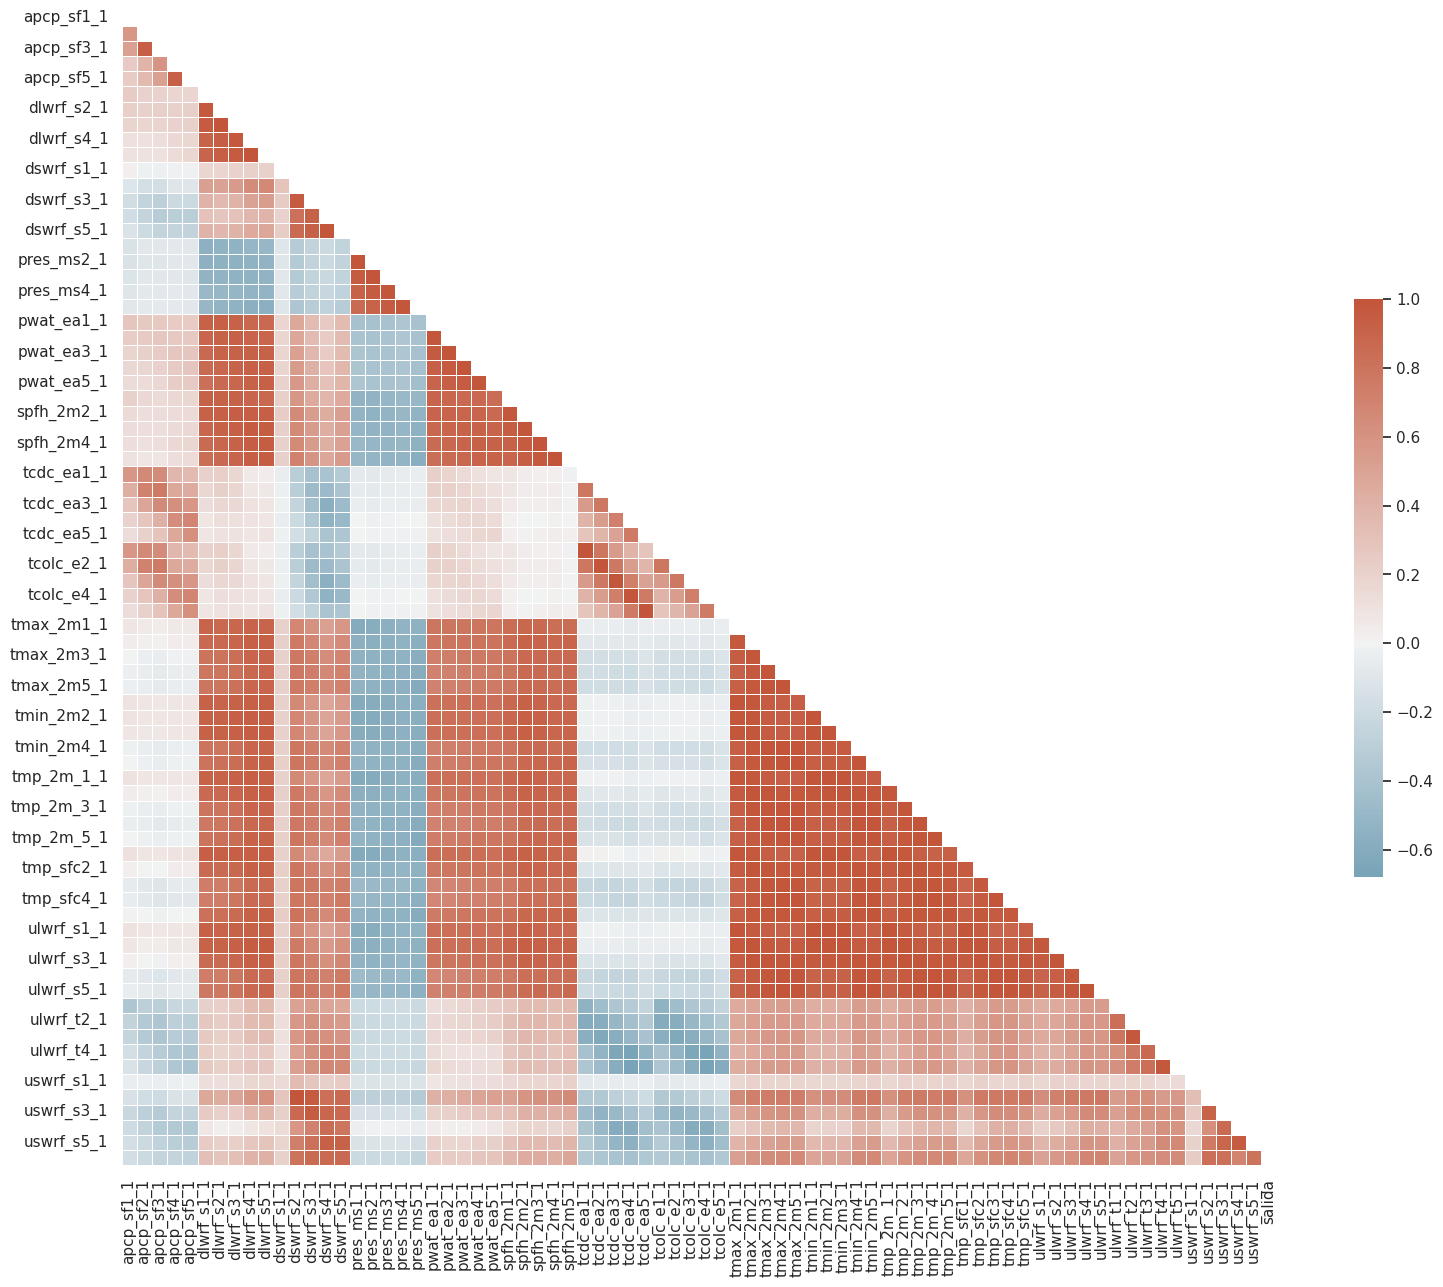

<Axes: >

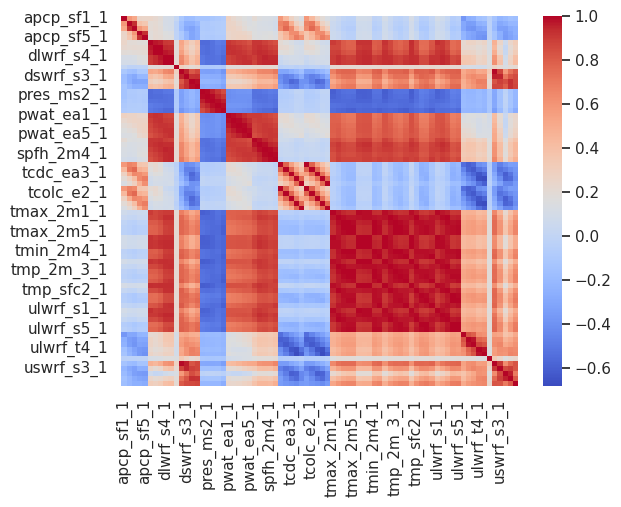

In [225]:
# Calcular la matriz de correlación
corr_matrix_disp = disp_df.corr()
corr_matrix_comp = comp_df.corr()

sns.set(style="white")
mask = np.triu(np.ones_like(corr_matrix_disp, dtype=bool))
f, ax = plt.subplots(figsize=(20, 15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix_disp, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

sns.heatmap(corr_matrix_disp, cmap='coolwarm')

En las figuras superiores pueden apreciarse dos figuras: una matriz de correlación y un mapa de calor. Ambas representan las correlaciones altas con un tono de rojo oscuro. Como puede verse, la alta correlación entre los atributos parece común en este dataset.

Como ejemplo de correlación se pueden estudiar dos atributos y su significado en el contexto del dataset.
En la matriz se aprecia que tcdc_ea1_1 y tcolc_e1_1 tienen una correlación muy alta. Esto es de esperar, pues el primero simboliza la cobertura total de nubes y el segundo la condensación de la atmósfera. 

### Eliminación de atributos

Gracias al EDA, es posible conocer qué atributos están muy correlacionados entre sí (por encima de 0.95). Teóricamente, dos atributos correlacionados pueden colapsar en uno solo, pues la información útil que aportan por separado es prácticamente idéntica a la que aporta solo uno de ellos. 

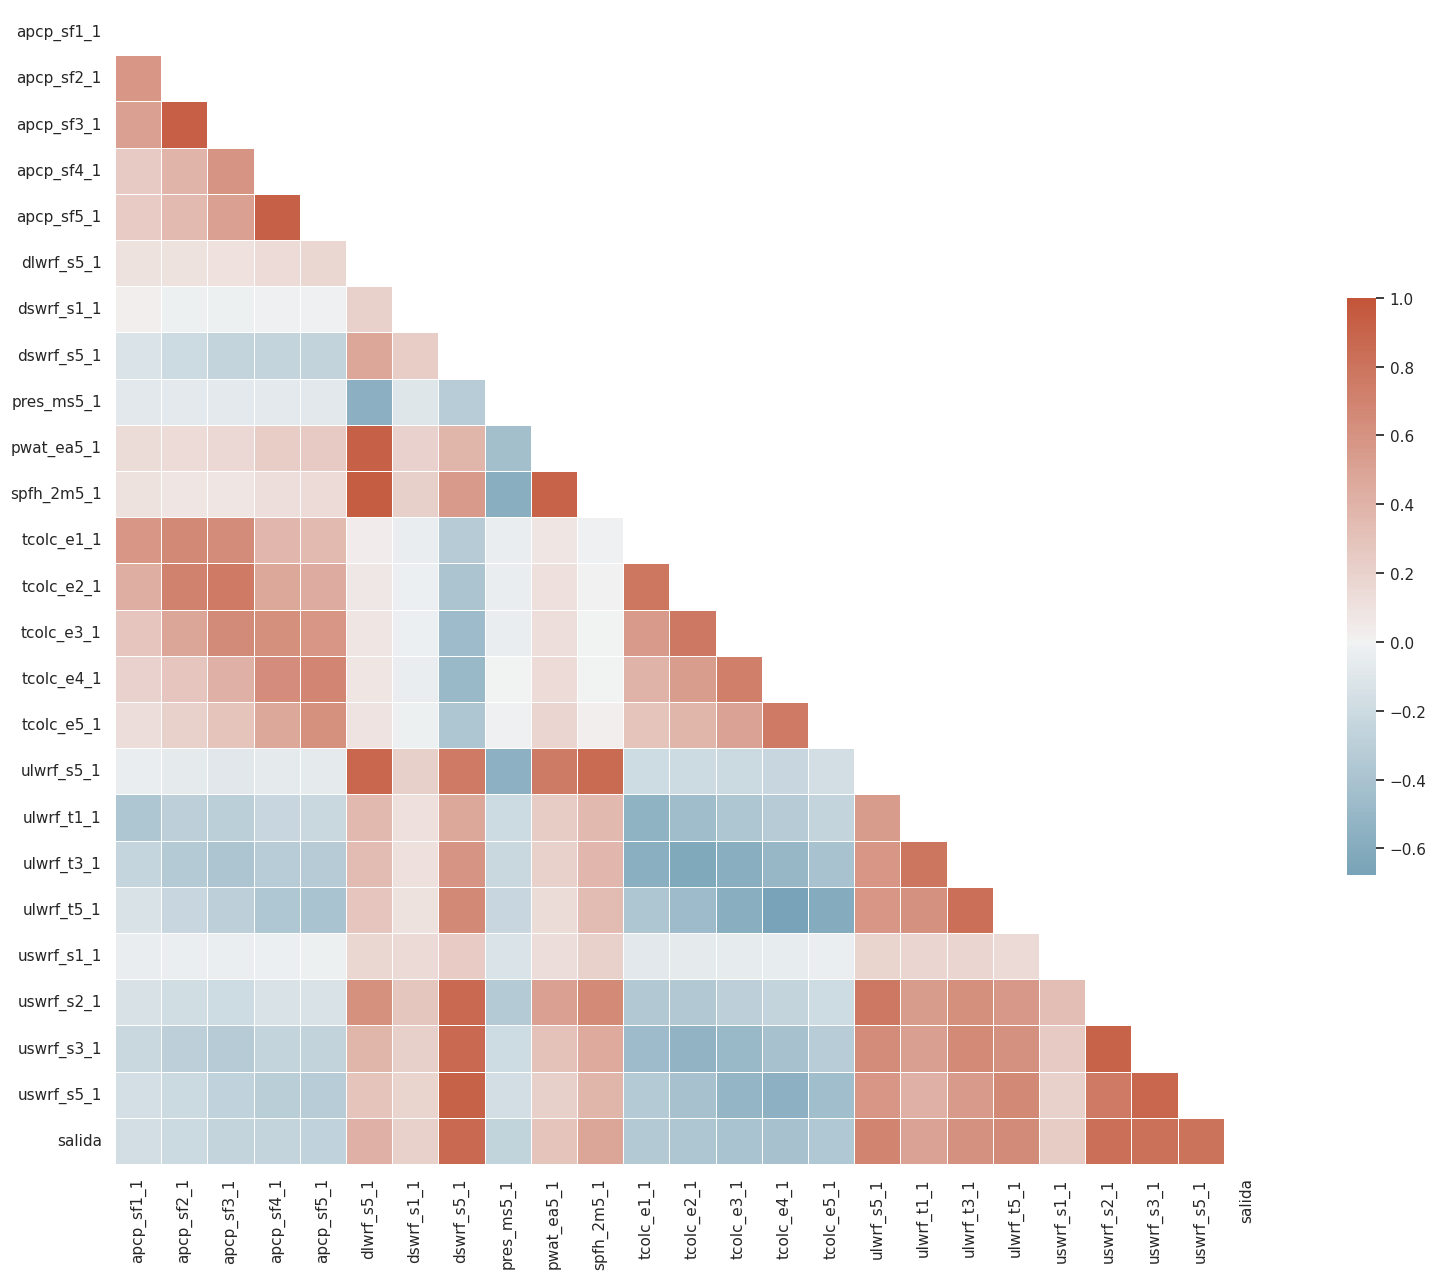

<Axes: >

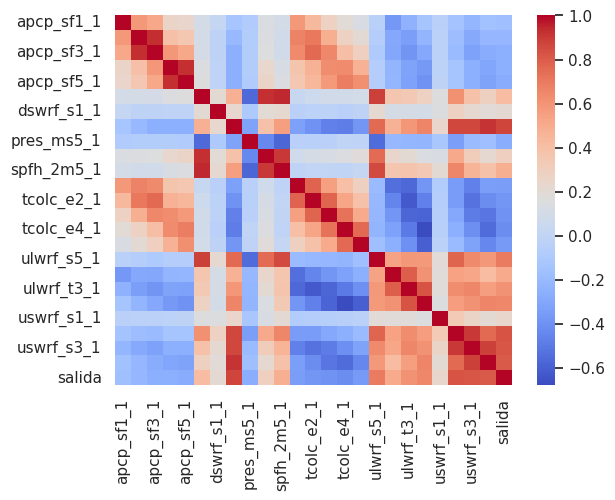

In [226]:
# Crear listas vacía para guardar pares de atributos con correlación mayor a 0.95
high_corr_pairs_disps = []
high_corr_pairs_comp = []

# Recorrer las matrizes de correlación para disps_df y comp_df
for i in range(len(corr_matrix_disp.columns)):
    for j in range(i):
        # Verificar si el coeficiente de correlación es mayor a 0.9 y diferentes entre sí
        if abs(corr_matrix_disp.iloc[i, j]) > 0.95 and corr_matrix_disp.columns[i] != corr_matrix_disp.columns[j]:
            # Guardar pares de atributos con correlación mayor a 0.9
            high_corr_pairs_disps.append((corr_matrix_disp.columns[i], corr_matrix_disp.columns[j]))

for i in range(len(corr_matrix_comp.columns)):
    for j in range(i):
        # Verificar si el coeficiente de correlación es mayor a 0.9 y diferentes entre sí
        if abs(corr_matrix_comp.iloc[i, j]) > 0.95 and corr_matrix_comp.columns[i] != corr_matrix_comp.columns[j]:
            # Guardar pares de atributos con correlación mayor a 0.9
            high_corr_pairs_comp.append((corr_matrix_comp.columns[i], corr_matrix_comp.columns[j]))

# Crear nuevos dataframe sin los atributos correlacionados
new_disp_df = disp_df.copy()
new_comp_df = comp_df.copy()

# Eliminar los atributos correlacionados
for attr_pair in high_corr_pairs_disps:
    if attr_pair[0] in new_disp_df.columns and attr_pair[1] in new_disp_df.columns:
        # Calcular la correlación entre los atributos
        corr = comp_df[attr_pair[0]].corr(comp_df[attr_pair[1]])
        #print(f'Eliminando atributo {attr_pair[1]} debido a la alta correlación con {attr_pair[0]} (corr={corr:.2f})')
        new_disp_df.drop(attr_pair[1], axis='columns', inplace=True)

for attr_pair in high_corr_pairs_comp:
    if attr_pair[0] in new_comp_df.columns and attr_pair[1] in new_comp_df.columns:
        corr = comp_df[attr_pair[0]].corr(comp_df[attr_pair[1]])
        new_comp_df.drop(attr_pair[1], axis='columns', inplace=True)

new_corr_matrix_disp = new_disp_df.corr()

sns.set(style="white")
mask = np.triu(np.ones_like(new_corr_matrix_disp, dtype=bool))
f, ax = plt.subplots(figsize=(20, 15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(new_corr_matrix_disp, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

sns.heatmap(new_corr_matrix_disp, cmap='coolwarm')

La matriz de correlación superior se ha generado utilizando el nuevo dataset. Este dataset se ha generado colapsando en uno los atributos que tienen un índice de correlación superior o igual a 0.95.

Se espera que con este dataset sea posible obtener mejores resultados y tiempos menores de entrenamiento. Esto último es esperable pues se ha reducido considerablemente la dimensionalidad de los datos.

# **3.PROCESAMIENTO DE DATOS**

## **DATASET DEFAULT**

**Normalización de valores**

Se lleva a cabo una normalización de los datos de entrada debido a que al tener cada variable un rango distinto, en algoritmos como el KNN las distancias no son equiparables.

In [227]:
# Seleccionar todas las columnas a normalizar
cols_to_norm_disp = disp_df.columns
cols_to_norm_comp = comp_df.columns

# Maximos y minimos para cada columna
dispMaxCol = disp_df[cols_to_norm_disp].max()
dispMinCol = disp_df[cols_to_norm_disp].min()

compMaxCol = comp_df[cols_to_norm_comp].max()
compMinCol = comp_df[cols_to_norm_comp].min()

# Escalar los valores de las columnas en el rango [0, 1]
disp_norm = (disp_df[cols_to_norm_disp] - dispMinCol) / (dispMaxCol - dispMinCol)
comp_norm = (comp_df[cols_to_norm_comp] - compMinCol) / (compMaxCol - compMinCol)

# Desnormalizar valor
disp_desnorm = disp_norm[cols_to_norm_disp] * (dispMaxCol - dispMinCol) + dispMinCol
comp_desnorm = comp_norm[cols_to_norm_comp] * (compMaxCol - compMinCol) + compMinCol

**Creación de conjuntos**

Los datos se dividen en dos conjuntos, el de entrenamiento, con el que se entrenará el modelo y el de test, con el que se evaluará el modelo.

El conjunto de entrenamiento a su vez se divide en dos, el conjunto de entrenamiento usado para construir modelos con distintos valores de hiperparámetros y el de validación, el cúal se usa para evaluar estos modelos generados.  

In [228]:
# Conjunto de datos no normalizados
train = disp_df.iloc[:3650]
test = disp_df.iloc[3650:]

# Tamaños de los conjuntos de datos
n_train = 2555
n_valid = 1095

# Conjunto de datos normalizados
train_norm = disp_norm.iloc[:3650]
test_norm = disp_norm.iloc[3650:]

# Conjunto de datos normalizados partidos
train_norm_train = disp_norm.iloc[:2555]
train_norm_val = disp_norm.iloc[2555:3650] 

**Predefined Split**

In [229]:
selector = [-1] * n_train + [0] * n_valid
cv = PredefinedSplit(selector)
split = cv.get_n_splits(disp_df)

**Randomización de las filas en los ficheros de train y test y valores de entrenamiento**

In [266]:
# Para la randomizacion de filas se usa la semilla 100429142
train_random = train.sample(frac=1, random_state=100429142).reset_index(drop=True)
test_random = test.sample(frac=1, random_state=100429142).reset_index(drop=True)

# Randomizacion de conjuntos normalizados
train_random_norm = train_norm.sample(frac=1, random_state=100429142).reset_index(drop=True)
test_random_norm = test_norm.sample(frac=1, random_state=100429142).reset_index(drop=True)


# ************** TRAIN 
# Separa las variables independientes (X) de la variable dependiente (y)
X_train = train_random.iloc[:, :-1]
Y_train = train_random.iloc[:, -1]

# Variables de conjunto de datos normalizado
X_train_norm = train_random_norm.iloc[:, :-1]
Y_train_norm = train_random_norm.iloc[:, -1]

# Variables de conjunto de datos normalizado partidos
X_train_train_norm = train_norm_train.iloc[:, :-1]
X_train_val_norm = train_norm_val.iloc[:, :-1]
Y_train_train_norm = train_norm_train.iloc[:, -1]
Y_train_val_norm = train_norm_val.iloc[:, -1]


# ************** TEST
X_test = test_random.iloc[:, :-1]
Y_test = test_random.iloc[:, -1]

X_test_norm = test_random_norm.iloc[:, :-1]
Y_test_norm = test_random_norm.iloc[:, -1]

## **DATASET EDA**

**Normalización de valores**

In [231]:
# Seleccionar todas las columnas a normalizar
new_cols_to_norm_disp = new_disp_df.columns
new_cols_to_norm_comp = new_comp_df.columns

# Maximos y minimos para cada columna
new_dispMaxCol = new_disp_df[new_cols_to_norm_disp].max()
new_dispMinCol = new_disp_df[new_cols_to_norm_disp].min()

new_compMaxCol = new_comp_df[new_cols_to_norm_comp].max()
new_compMinCol = new_comp_df[new_cols_to_norm_comp].min()

# Escalar los valores de las columnas en el rango [0, 1]
new_disp_norm = (new_disp_df[new_cols_to_norm_disp] - new_dispMinCol) / (new_dispMaxCol - new_dispMinCol)
new_comp_norm = (new_comp_df[new_cols_to_norm_comp] - new_compMinCol) / (new_compMaxCol - new_compMinCol)

# Desnormalizar valor
new_disp_desnorm = new_disp_norm[new_cols_to_norm_disp] * (new_dispMaxCol - new_dispMinCol) + new_dispMinCol
new_comp_desnorm = new_comp_norm[new_cols_to_norm_comp] * (new_compMaxCol - new_compMinCol) + new_compMinCol

**Creación de conjuntos**

In [232]:
# Conjunto de datos no normalizados
new_train = disp_df.iloc[:3650]
new_test = disp_df.iloc[3650:]

# Tamaños de los conjuntos de datos
new_n_train = 2555
new_n_valid = 1095

# Conjunto de datos normalizados
new_train_norm = new_disp_norm.iloc[:3650]
new_test_norm = new_disp_norm.iloc[3650:]

# Conjunto de datos normalizados partidos
new_train_norm_train = new_disp_norm.iloc[:2555]
new_train_norm_val = new_disp_norm.iloc[2555:3650]

**Predefined Split para optimización de parámetros**

In [233]:
new_selector = [-1] * new_n_train + [0] * new_n_valid
new_cv = PredefinedSplit(new_selector)
new_split = new_cv.get_n_splits(new_disp_df)

**Randomización de las filas en los ficheros de train y test y valores de entrenamiento**

In [267]:
# Para la randomizacion de filas se usa la semilla 100429142
new_train_random = new_train.sample(frac=1, random_state=100429142).reset_index(drop=True)
new_test_random = new_test.sample(frac=1, random_state=100429142).reset_index(drop=True)

# Randomizacion de conjuntos normalizados
new_train_random_norm = new_train_norm.sample(frac=1, random_state=100429142).reset_index(drop=True)
new_test_random_norm = new_test_norm.sample(frac=1, random_state=100429142).reset_index(drop=True)


# ************** TRAIN 
# Separa las variables independientes (X) de la variable dependiente (y)
new_X_train = train_random.iloc[:, :-1]
new_Y_train = train_random.iloc[:, -1]

# Variables de conjunto de datos normalizado
new_X_train_norm = new_train_random_norm.iloc[:, :-1]
new_Y_train_norm = new_train_random_norm.iloc[:, -1]

# Variables de conjunto de datos normalizado partidos
new_X_train_train_norm = new_train_norm_train.iloc[:, :-1]
new_X_train_val_norm = new_train_norm_val.iloc[:, :-1]
new_Y_train_train_norm = new_train_norm_train.iloc[:, -1]
new_Y_train_val_norm = new_train_norm_val.iloc[:, -1]


# ************** TEST
new_X_test = train_random.iloc[:, :-1]
new_Y_test = train_random.iloc[:, -1]

new_X_test_norm = new_test_random_norm.iloc[:, :-1]
new_Y_test_norm = new_test_random_norm.iloc[:, -1]

# **4.MODELOS BÁSICOS**

## **4.1.OMISIÓN DE HIPERPARÁMETROS**

### Modelo KNN

In [235]:
# USA LOS VALORES NORMALIZADOS
# EXPLICAR PORQUE SE NORMALIZA CON EL KNN
# TIENE 5 NEIGHBORS POR DEFECTO

# Crear el modelo con los parámetros por defecto
knn = KNeighborsRegressor()

# ********** DATASET DEFAULT **********
# Iniciar la medición del tiempo
start_time = time.time()

# Ajustar el modelo con train_norm_train
knn_fit_train = knn.fit(X_train_train_norm, Y_train_train_norm)

# Finalizar la medición del tiempo y calculo del tiempo
end_time = time.time()
knn_training_time = round((end_time - start_time) * 1000, 6)

# Calcular las predicciones y los errores de validación
y_pred_val = knn_fit_train.predict(X_train_val_norm)
knn_mae_val = mean_absolute_error(Y_train_val_norm, y_pred_val)
knn_rmse_val = np.sqrt(mean_squared_error(Y_train_val_norm, y_pred_val))

# Calcular las predicciones y los errores de entrenamiento
y_pred_train = knn_fit_train.predict(X_train_train_norm)
knn_mae_train = mean_absolute_error(Y_train_train_norm, y_pred_train)
knn_rmse_train = np.sqrt(mean_squared_error(Y_train_train_norm, y_pred_train))


# ********** DATASET NUEVO **********
start_time = time.time()

new_knn_fit_train = knn.fit(new_X_train_train_norm, new_Y_train_train_norm)

end_time = time.time()
new_knn_training_time = round((end_time - start_time) * 1000, 6)

new_y_pred_val = new_knn_fit_train.predict(new_X_train_val_norm)
new_knn_mae_val = mean_absolute_error(new_Y_train_val_norm, new_y_pred_val)
new_knn_rmse_val = np.sqrt(mean_squared_error(new_Y_train_val_norm, new_y_pred_val))

new_y_pred_train = new_knn_fit_train.predict(new_X_train_train_norm)
new_knn_mae_train = mean_absolute_error(new_Y_train_train_norm, new_y_pred_train)
new_knn_rmse_train = np.sqrt(mean_squared_error(new_Y_train_train_norm, new_y_pred_train))

### Modelo Árbol de decisión 

In [236]:
# EXPLICAR EL SOBREAPRENDIZAJE SI NO SE LIMITA LA MAX_DEPTH
# ACABA CON 2^N HOJAS (CADA HOJA ES UN VALOR DE SALIDA)

# Crear el modelo con los parámetros por defecto
tree = DecisionTreeRegressor()

# ********** DATASET DEFAULT **********
# Iniciar la medición del tiempo
start_time = time.time()

tree_fit = tree.fit(X_train_train_norm, Y_train_train_norm)

# Finalizar la medición del tiempo y calculo del tiempo
end_time = time.time()
tree_training_time = round((end_time - start_time) * 1000, 6)

# Calcular las predicciones y los errores de validación
y_pred_val = tree_fit.predict(X_train_val_norm)
tree_mae_val = mean_absolute_error(Y_train_val_norm, y_pred_val)
tree_rmse_val = np.sqrt(mean_squared_error(Y_train_val_norm, y_pred_val))

# Calcular las predicciones y los errores de entrenamiento
y_pred_train = tree_fit.predict(X_train_train_norm)
tree_mae_train = mean_absolute_error(Y_train_train_norm, y_pred_train)
tree_rmse_train = np.sqrt(mean_squared_error(Y_train_train_norm, y_pred_train))


# ********** DATASET NUEVO **********
start_time = time.time()

new_tree_fit = tree.fit(new_X_train_train_norm, new_Y_train_train_norm)

end_time = time.time()
new_tree_training_time = round((end_time - start_time) * 1000, 6)

new_y_pred_val = new_tree_fit.predict(new_X_train_val_norm)
new_tree_mae_val = mean_absolute_error(new_Y_train_val_norm, new_y_pred_val)
new_tree_rmse_val = np.sqrt(mean_squared_error(new_Y_train_val_norm, new_y_pred_val))

new_y_pred_train = new_tree_fit.predict(new_X_train_train_norm)
new_tree_mae_train = mean_absolute_error(new_Y_train_train_norm, new_y_pred_train)
new_tree_rmse_train = np.sqrt(mean_squared_error(new_Y_train_train_norm, new_y_pred_train))

### Modelo Árbol de regresión lineal 

In [237]:
# Crear modelo
model_rl = LinearRegression()

# ********** DATASET DEFAULT **********
# Iniciar la medición del tiempo
start_time = time.time()

# Entrenar modelo
reg_fit = model_rl.fit(X_train_train_norm, Y_train_train_norm)

# Finalizar la medición del tiempo y calculo del tiempo
end_time = time.time()
reg_training_time = round((end_time - start_time) * 1000, 6)

# Calcular las predicciones y los errores de validación
y_pred_val = reg_fit.predict(X_train_val_norm)
reg_mae_val = mean_absolute_error(Y_train_val_norm, y_pred_val)
reg_rmse_val = np.sqrt(mean_squared_error(Y_train_val_norm, y_pred_val))

# Calcular las predicciones y los errores de entrenamiento
y_pred_train = reg_fit.predict(X_train_train_norm)
reg_mae_train = mean_absolute_error(Y_train_train_norm, y_pred_train)
reg_rmse_train = np.sqrt(mean_squared_error(Y_train_train_norm, y_pred_train))


# ********** DATASET NUEVO **********
start_time = time.time()

new_reg_fit = model_rl.fit(new_X_train_train_norm, new_Y_train_train_norm)

end_time = time.time()
new_reg_training_time = round((end_time - start_time) * 1000, 6)

new_y_pred_val = new_reg_fit.predict(new_X_train_val_norm)
new_reg_mae_val = mean_absolute_error(new_Y_train_val_norm, new_y_pred_val)
new_reg_rmse_val = np.sqrt(mean_squared_error(new_Y_train_val_norm, new_y_pred_val))

new_y_pred_train = new_reg_fit.predict(new_X_train_train_norm)
new_reg_mae_train = mean_absolute_error(new_Y_train_train_norm, new_y_pred_train)
new_reg_rmse_train = np.sqrt(mean_squared_error(new_Y_train_train_norm, new_y_pred_train))

## **4.2.COMPARATIVA OMISIÓN DE HIPERPARÁMETROS**

En la tabla se recogen los distintos resultados obtenidos del MAE de entrenamiento y validación, el RMSE de entrenamiento y validación y el tiempo de entrenamiento de cada uno de los modelos básicos con omisión de hiperparámetros.

Estos datos serán analizados de manera gráfica a continuación mostrándose tanto los resultados obtenidos con el dataset original, como los obtenidos tras realizar el EDA.

In [238]:
# ********** DATASET DEFAULT **********
# Crear un diccionario con los valores de MAE, RMSE y tiempo de ejecución de cada modelo
data = {'KNN': [knn_mae_train, knn_mae_val, knn_rmse_train, knn_rmse_val, knn_training_time],
        'Árbol de decisión': [tree_mae_train, tree_mae_val, tree_rmse_train, tree_rmse_val, tree_training_time],
        'Regresión lineal': [reg_mae_train, reg_mae_val, reg_rmse_train, reg_rmse_val, reg_training_time]}

# Crear un DataFrame de pandas con los valores del diccionario y especificar las etiquetas de filas y columnas
df = pd.DataFrame(data, index=['MAE train', 'MAE val', 'RMSE train', 'RMSE val', 'Tiempo de entrenamiento (ms)'])


# ********** DATASET NUEVO **********
new_data = {'KNN': [new_knn_mae_train, new_knn_mae_val, new_knn_rmse_train, new_knn_rmse_val, new_knn_training_time],
        'Árbol de decisión': [new_tree_mae_train, new_tree_mae_val, new_tree_rmse_train, new_tree_rmse_val, new_tree_training_time],
        'Regresión lineal': [new_reg_mae_train, new_reg_mae_val, new_reg_rmse_train, new_reg_rmse_val, new_reg_training_time]}

new_df = pd.DataFrame(new_data, index=['MAE train', 'MAE val', 'RMSE train', 'RMSE val', 'Tiempo de entrenamiento (ms)'])

print("Tabla default")
display(df)

print("\n")
print("Tabla EDA")
display(new_df)

Tabla default


,KNN,Árbol de decisión,Regresión lineal
MAE train,0.063843,0.000000,0.068970
MAE val,0.080653,0.100877,0.072994
RMSE train,0.094861,0.000000,0.099724
RMSE val,0.122158,0.153352,0.108323
Tiempo de entrenamiento (ms),4.558325,297.600269,28.196812




Tabla EDA


,KNN,Árbol de decisión,Regresión lineal
MAE train,0.063180,0.000000,0.072213
MAE val,0.083259,0.100663,0.075420
RMSE train,0.095753,0.000000,0.104678
RMSE val,0.125316,0.151122,0.112611
Tiempo de entrenamiento (ms),2.868414,84.564924,26.299715


### Comparativa del MAE


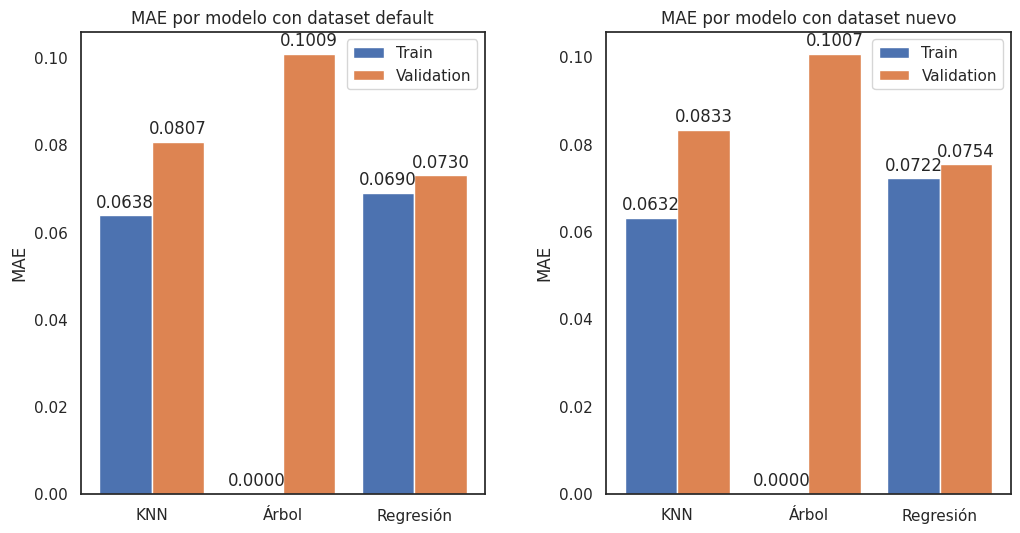

In [239]:
# Agregar las etiquetas a las barras
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.4f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Crear los datos para los modelos
modelos = ['KNN', 'Árbol', 'Regresión']
mae_train = [knn_mae_train, tree_mae_train, reg_mae_train]
mae_val = [knn_mae_val, tree_mae_val, reg_mae_val]

new_mae_train = [new_knn_mae_train, new_tree_mae_train, new_reg_mae_train]
new_mae_val = [new_knn_mae_val, new_tree_mae_val, new_reg_mae_val]

# Configurar la figura con dos conjuntos de ejes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Graficar la primera gráfica en el primer conjunto de ejes
ind = np.arange(len(modelos))
ancho = 0.4
rects1 = ax1.bar(ind - ancho/2, mae_train, ancho, label='Train')
rects2 = ax1.bar(ind + ancho/2, mae_val, ancho, label='Validation')
ax1.set_ylabel('MAE')
ax1.set_title('MAE por modelo con dataset default')
ax1.set_xticks(ind)
ax1.set_xticklabels(modelos)
ax1.legend()
autolabel(rects1, ax1)
autolabel(rects2, ax1)

# Graficar la segunda gráfica en el segundo conjunto de ejes
rects1_2 = ax2.bar(ind - ancho/2, new_mae_train, ancho, label='Train')
rects2_2 = ax2.bar(ind + ancho/2, new_mae_val, ancho, label='Validation')
ax2.set_ylabel('MAE')
ax2.set_title('MAE por modelo con dataset nuevo')
ax2.set_xticks(ind)
ax2.set_xticklabels(modelos)
ax2.legend()
autolabel(rects1_2, ax2)
autolabel(rects2_2, ax2)

# Ajustar el margen entre las dos gráficas
fig.subplots_adjust(wspace=0.3)

# Mostrar la gráfica
plt.show()

En el dataset default se puede observar que el menor MAE en train es el del árbol de decisión, este es de 0. Esto significa que el modelo se está ajustando perfectamente a las instancias de entrenamiento, aunque estudiando el error de validación para el árbol, es aparente que se produce un un sobreajuste en el entrenamiento. Este sobreajuste es debido a que un árbol de decisión sin limitación en su profundidad (max_depth) puede expandirse hasta que en cada nodo hoja se pueda clasificar cada una de las instancias, obteniéndose ese error de 0 (2^n hojas).

Fuera de este sobreajuste, el KNN obtiene el mejor MAE en train aunque sus predicciones no son del todo precisas (se aprecia algo de sobreajuste estudiando su MAE en validación). El modelo más equilibrado entre el MAE de entrenamiento y de validación es la regresión lineal.

En cuanto al dataset tras hacer el EDA, los resultados son muy parecidos a los del dataset original, obteniéndose el mejor MAE en el KNN y siendo la regresión lineal el más equilibrado entre train y validation.



### Comparativa del RMSE

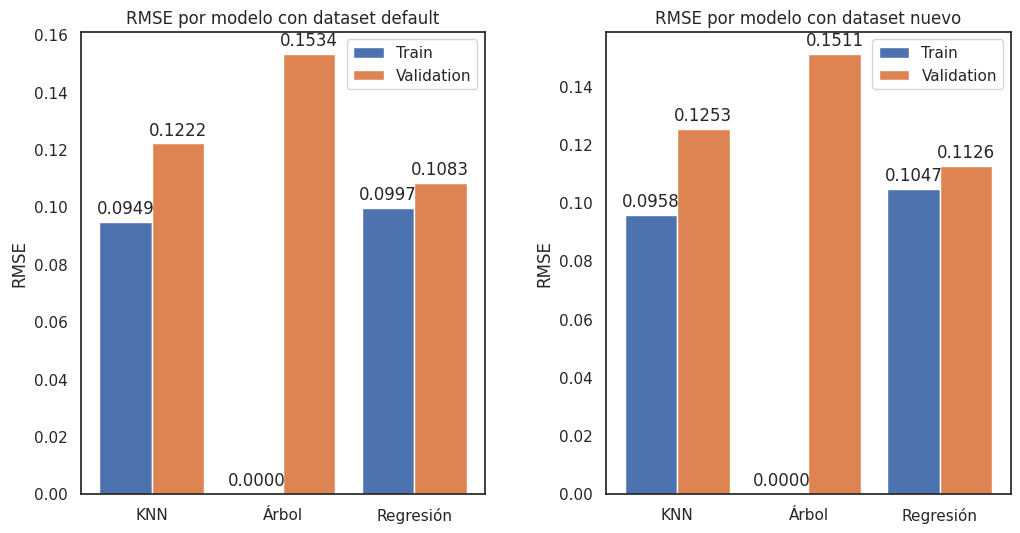

In [240]:
# Agregar las etiquetas a las barras
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.4f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Crear los datos para los modelos
modelos = ['KNN', 'Árbol', 'Regresión']
rmse_train = [knn_rmse_train, tree_rmse_train, reg_rmse_train]
rmse_val = [knn_rmse_val, tree_rmse_val, reg_rmse_val]

new_rmse_train = [new_knn_rmse_train, new_tree_rmse_train, new_reg_rmse_train]
new_rmse_val = [new_knn_rmse_val, new_tree_rmse_val, new_reg_rmse_val]

# Configurar la figura con dos conjuntos de ejes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Graficar la primera gráfica en el primer conjunto de ejes
ind = np.arange(len(modelos))
ancho = 0.4
rects1 = ax1.bar(ind - ancho/2, rmse_train, ancho, label='Train')
rects2 = ax1.bar(ind + ancho/2, rmse_val, ancho, label='Validation')
ax1.set_ylabel('RMSE')
ax1.set_title('RMSE por modelo con dataset default')
ax1.set_xticks(ind)
ax1.set_xticklabels(modelos)
ax1.legend()
autolabel(rects1, ax1)
autolabel(rects2, ax1)

# Graficar la segunda gráfica en el segundo conjunto de ejes
rects1_2 = ax2.bar(ind - ancho/2, new_rmse_train, ancho, label='Train')
rects2_2 = ax2.bar(ind + ancho/2, new_rmse_val, ancho, label='Validation')
ax2.set_ylabel('RMSE')
ax2.set_title('RMSE por modelo con dataset nuevo')
ax2.set_xticks(ind)
ax2.set_xticklabels(modelos)
ax2.legend()
autolabel(rects1_2, ax2)
autolabel(rects2_2, ax2)

# Ajustar el margen entre las dos gráficas
fig.subplots_adjust(wspace=0.3)

# Mostrar la gráfica
plt.show()

Los valores obtenidos para el RMSE son bastante similares a los obtenidos con el cálculo del MAE, teniéndo las gráficas formas prácticamente iguales.

En el caso del dataset del EDA, los valores del KNN y del árbol de decisión son prácticamente iguales, mientras que los de la regresión lineal son ligeramente peores.


### Comparativa del tiempo de entrenamiento

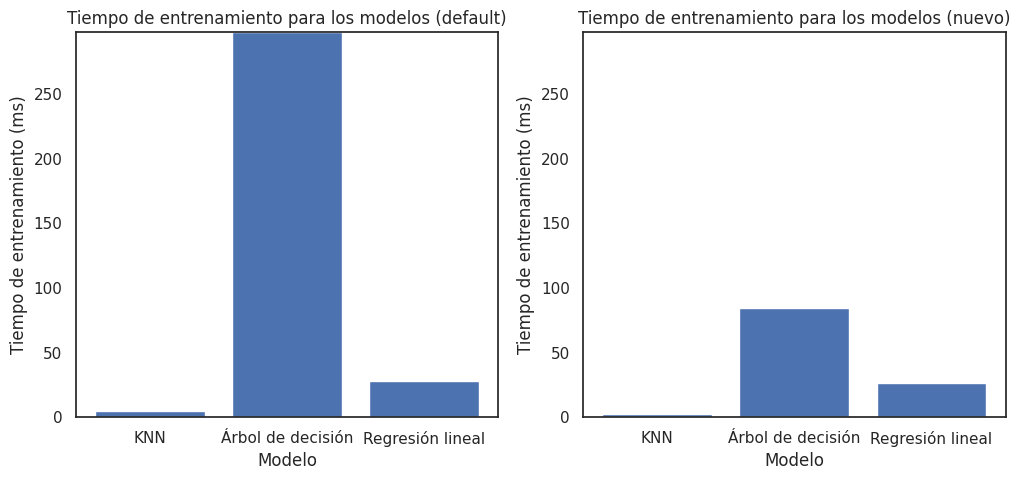

In [241]:
# Obtener el valor máximo de tiempo de entrenamiento entre ambos dataframes
max_time = max(df.loc['Tiempo de entrenamiento (ms)'].max(), new_df.loc['Tiempo de entrenamiento (ms)'].max())

# Gráfico DEFAULT
# Obtener los valores de tiempo de entrenamiento para cada modelo
time_values = df.loc['Tiempo de entrenamiento (ms)']

# Crear un gráfico de barras
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].bar(time_values.index, time_values.values)

# Personalizar el gráfico
axs[0].set_title('Tiempo de entrenamiento para los modelos (default)')
axs[0].set_xlabel('Modelo')
axs[0].set_ylabel('Tiempo de entrenamiento (ms)')
axs[0].set_ylim([0, max_time])

# Gráfico NUEVO
# Obtener los valores de tiempo de entrenamiento para cada modelo
new_time_values = new_df.loc['Tiempo de entrenamiento (ms)']

# Crear un gráfico de barras
axs[1].bar(new_time_values.index, new_time_values.values)

# Personalizar el gráfico
axs[1].set_title('Tiempo de entrenamiento para los modelos (nuevo)')
axs[1].set_xlabel('Modelo')
axs[1].set_ylabel('Tiempo de entrenamiento (ms)')
axs[1].set_ylim([0, max_time])

plt.show()

Como es observable a simple vista, el modelo que más tarda es el árbol de decisión, esto puede deberse a que el modelo desarrolla una complejidad muy alta debido a la gran profundidad del algoritmo.

El modelo que arroja un menjor resultado en cuanto al tiempo es el del KNN, el cuál mantiene una amplia ventaja frente a la regresión lineal.

En el dataset nuevo, se obtienen valores de tiempo mucho menores. Esto tiene sentido debido a que el tamaño del dataset tras el EDA es bastante menor al tamaño del dataset original.


## **4.3.OPTIMIZACIÓN DE HIPERPARÁMETROS**




### Modelo KNN

In [265]:
knn = KNeighborsRegressor()

# Definir cuadrícula de valores de hiperparámetros a explorar
param_grid = {'n_neighbors': [7, 8, 9, 10, 11, 12, 15], 'p': [1, 2]}

# Definir métricas de evaluación a utilizar
scoring = {'MAE': make_scorer(mean_absolute_error, greater_is_better=False), 'RMSE': make_scorer(mean_squared_error, squared=False, greater_is_better=False)}

# ************ DATASET DEFAULT
grid_search = GridSearchCV(knn, param_grid=param_grid, scoring=scoring, refit='MAE', cv=cv)
grid_search.fit(X_train_norm, Y_train_norm)

best_n_neighbors = grid_search.best_params_['n_neighbors']
best_p = grid_search.best_params_['p']

#Crear un nuevo modelo con los mejores valores de los hiperparámetros
knn_opt = KNeighborsRegressor(n_neighbors=best_n_neighbors, p=best_p)

#Iniciar la medición del tiempo
start_time = time.time()

#Ajustar el modelo con train_norm
knn_opt_fit_train = knn_opt.fit(X_train_norm, Y_train_norm)

#Finalizar la medición del tiempo y calculo del tiempo
end_time = time.time()
knn_opt_training_time = round((end_time - start_time) * 1000, 6)

#Calcular las predicciones y los errores de validación
y_pred_val = knn_opt_fit_train.predict(X_train_val_norm)
knn_opt_mae_val = mean_absolute_error(Y_train_val_norm, y_pred_val)
knn_opt_rmse_val = np.sqrt(mean_squared_error(Y_train_val_norm, y_pred_val))

#Calcular las predicciones y los errores de entrenamiento
y_pred_train = knn_opt_fit_train.predict(X_train_train_norm)
knn_opt_mae_train = mean_absolute_error(Y_train_train_norm, y_pred_train)
knn_opt_rmse_train = np.sqrt(mean_squared_error(Y_train_train_norm, y_pred_train))


# ************** DATASET NUEVO
new_grid_search = GridSearchCV(knn, param_grid=param_grid, scoring=scoring, refit='MAE', cv=new_cv)
new_grid_search.fit(new_X_train_norm, new_Y_train_norm)

new_best_n_neighbors = new_grid_search.best_params_['n_neighbors']
new_best_p = new_grid_search.best_params_['p']

#Crear un nuevo modelo con los mejores valores de los hiperparámetros
new_knn_opt = KNeighborsRegressor(n_neighbors=new_best_n_neighbors, p=new_best_p)

#Iniciar la medición del tiempo
start_time = time.time()

#Ajustar el modelo con train_norm
new_knn_opt_fit_train = new_knn_opt.fit(new_X_train_norm, new_Y_train_norm)

#Finalizar la medición del tiempo y calculo del tiempo
end_time = time.time()
new_knn_opt_training_time = round((end_time - start_time) * 1000, 6)

#Calcular las predicciones y los errores de validación
new_y_pred_val = new_knn_opt_fit_train.predict(new_X_train_val_norm)
new_knn_opt_mae_val = mean_absolute_error(new_Y_train_val_norm, new_y_pred_val)
new_knn_opt_rmse_val = np.sqrt(mean_squared_error(new_Y_train_val_norm, new_y_pred_val))

#Calcular las predicciones y los errores de entrenamiento
new_y_pred_train = new_knn_opt_fit_train.predict(new_X_train_train_norm)
new_knn_opt_mae_train = mean_absolute_error(new_Y_train_train_norm, new_y_pred_train)
new_knn_opt_rmse_train = np.sqrt(mean_squared_error(new_Y_train_train_norm, new_y_pred_train))


# ************** PRINT HIPERPARÁMETROS ÓPTIMOS
print("Hiperparámetros óptimos para el dataset DEFAULT: n_neighbors: ", best_n_neighbors, ",p: ", best_p)
print("Hiperparámetros óptimos para el dataset NUEVO: n_neighbors: ", new_best_n_neighbors, ",p: ", new_best_p)

Hiperparámetros óptimos para el dataset DEFAULT: n_neighbors:  10 , p:  1
Hiperparámetros óptimos para el dataset NUEVO: n_neighbors:  15 , p:  1


### Modelo Árbol de Decisión

In [243]:
# Definir el modelo
tree = DecisionTreeRegressor()

# Definir los parámetros a probar
param_grid = {'max_depth': [3, 5, 7, 9], 'min_samples_leaf': [1, 2, 4, 8]}

scoring = {'MAE': make_scorer(mean_absolute_error, greater_is_better=False), 'RMSE': make_scorer(mean_squared_error, squared=False, greater_is_better=False)}

# ************ DATASET DEFAULT
# Definir la búsqueda por validación cruzada
grid_search = GridSearchCV(tree, param_grid=param_grid, cv=cv, refit='MAE', scoring=scoring) #'neg_mean_squared_error'

# Entrenar el modelo con los datos de entrenamiento
grid_search.fit(X_train_norm, Y_train_norm)

best_max_depth = grid_search.best_params_['max_depth']
best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']

#Crear un nuevo modelo con los mejores valores de los hiperparámetros
tree_opt = DecisionTreeRegressor(max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf)

#Iniciar la medición del tiempo
start_time = time.time()

#Ajustar el modelo con train_norm
tree_opt_fit_train = tree_opt.fit(X_train_norm, Y_train_norm)

#Finalizar la medición del tiempo y calculo del tiempo
end_time = time.time()
tree_opt_training_time = round((end_time - start_time) * 1000, 6)

#Calcular las predicciones y los errores de validación
y_pred_val = tree_opt_fit_train.predict(X_train_val_norm)
tree_opt_mae_val = mean_absolute_error(Y_train_val_norm, y_pred_val)
tree_opt_rmse_val = np.sqrt(mean_squared_error(Y_train_val_norm, y_pred_val))

#Calcular las predicciones y los errores de entrenamiento
y_pred_train = tree_opt_fit_train.predict(X_train_train_norm)
tree_opt_mae_train = mean_absolute_error(Y_train_train_norm, y_pred_train)
tree_opt_rmse_train = np.sqrt(mean_squared_error(Y_train_train_norm, y_pred_train))


# ************** DATASET NUEVO
new_grid_search = GridSearchCV(tree, param_grid=param_grid, cv=new_cv, refit='MAE', scoring=scoring)

new_grid_search.fit(new_X_train_norm, new_Y_train_norm)

new_best_max_depth = new_grid_search.best_params_['max_depth']
new_best_min_samples_leaf = new_grid_search.best_params_['min_samples_leaf']

new_tree_opt = DecisionTreeRegressor(max_depth=new_best_max_depth, min_samples_leaf=new_best_min_samples_leaf)

start_time = time.time()

new_tree_opt_fit_train = new_tree_opt.fit(new_X_train_norm, new_Y_train_norm)

end_time = time.time()
new_tree_opt_training_time = round((end_time - start_time) * 1000, 6)

new_y_pred_val = new_tree_opt_fit_train.predict(new_X_train_val_norm)
new_tree_opt_mae_val = mean_absolute_error(new_Y_train_val_norm, new_y_pred_val)
new_tree_opt_rmse_val = np.sqrt(mean_squared_error(new_Y_train_val_norm, new_y_pred_val))

new_y_pred_train = new_tree_opt_fit_train.predict(new_X_train_train_norm)
new_tree_opt_mae_train = mean_absolute_error(new_Y_train_train_norm, new_y_pred_train)
new_tree_opt_rmse_train = np.sqrt(mean_squared_error(new_Y_train_train_norm, new_y_pred_train))

### Modelo Árbol de Regresión Lineal

#### RIDGE

In [244]:
# Crear modelo
ridge = Ridge()

# Definir los parámetros a probar
param_grid = {'alpha': [0.2, 0.4, 0.6, 0.8, 1]}

scoring = {'MAE': make_scorer(mean_absolute_error, greater_is_better=False), 'RMSE': make_scorer(mean_squared_error, squared=False, greater_is_better=False)}


# ************ DATASET DEFAULT
# Definir la búsqueda por validación cruzada
grid_search = GridSearchCV(ridge, param_grid=param_grid, cv=cv, refit='MAE', scoring=scoring) #'neg_mean_squared_error'

# Entrenar el modelo con los datos de entrenamiento
grid_search.fit(X_train_norm, Y_train_norm)

best_alpha = grid_search.best_params_['alpha']

#Crear un nuevo modelo con los mejores valores de los hiperparámetros
ridge_opt = Ridge(alpha=best_alpha)
# Iniciar la medición del tiempo
start_time = time.time()

# Entrenar modelo
ridge_opt_fit = ridge_opt.fit(X_train_train_norm, Y_train_train_norm)

# Finalizar la medición del tiempo y calculo del tiempo
end_time = time.time()
ridge_opt_training_time = round((end_time - start_time) * 1000, 6)

# Calcular las predicciones y los errores de validación
y_pred_val = ridge_opt_fit.predict(X_train_val_norm)
ridge_opt_mae_val = mean_absolute_error(Y_train_val_norm, y_pred_val)
ridge_opt_rmse_val = np.sqrt(mean_squared_error(Y_train_val_norm, y_pred_val))

# Calcular las predicciones y los errores de entrenamiento
y_pred_train = ridge_opt_fit.predict(X_train_train_norm)
ridge_opt_mae_train = mean_absolute_error(Y_train_train_norm, y_pred_train)
ridge_opt_rmse_train = np.sqrt(mean_squared_error(Y_train_train_norm, y_pred_train))


# ************** DATASET NUEVO
new_grid_search = GridSearchCV(ridge, param_grid=param_grid, cv=new_cv, refit='MAE', scoring=scoring)

new_grid_search.fit(new_X_train_norm, new_Y_train_norm)

new_best_alpha = new_grid_search.best_params_['alpha']

new_ridge_opt = Ridge(alpha=new_best_alpha)
start_time = time.time()

new_ridge_opt_fit = new_ridge_opt.fit(new_X_train_train_norm, new_Y_train_train_norm)

end_time = time.time()
new_ridge_opt_training_time = round((end_time - start_time) * 1000, 6)

new_y_pred_val = new_ridge_opt_fit.predict(new_X_train_val_norm)
new_ridge_opt_mae_val = mean_absolute_error(new_Y_train_val_norm, new_y_pred_val)
new_ridge_opt_rmse_val = np.sqrt(mean_squared_error(new_Y_train_val_norm, new_y_pred_val))

new_y_pred_train = new_ridge_opt_fit.predict(new_X_train_train_norm)
new_ridge_opt_mae_train = mean_absolute_error(new_Y_train_train_norm, new_y_pred_train)
new_ridge_opt_rmse_train = np.sqrt(mean_squared_error(new_Y_train_train_norm, new_y_pred_train))

#### LASSO

In [245]:
# Crear modelo
lasso = Lasso()

# Definir los parámetros a probar
param_grid = {'alpha': [0.2, 0.4, 0.6, 0.8, 1]}

scoring = {'MAE': make_scorer(mean_absolute_error, greater_is_better=False), 'RMSE': make_scorer(mean_squared_error, squared=False, greater_is_better=False)}


# ************ DATASET DEFAULT
# Definir la búsqueda por validación cruzada
grid_search = GridSearchCV(lasso, param_grid=param_grid, cv=cv, refit='MAE', scoring=scoring)

# Entrenar el modelo con los datos de entrenamiento
grid_search.fit(X_train_norm, Y_train_norm)

best_alpha = grid_search.best_params_['alpha']

#Crear un nuevo modelo con los mejores valores de los hiperparámetros
lasso_opt = Lasso(alpha=best_alpha)

# Iniciar la medición del tiempo
start_time = time.time()

# Entrenar modelo
lasso_opt_fit = lasso_opt.fit(X_train_train_norm, Y_train_train_norm)

# Finalizar la medición del tiempo y calculo del tiempo
end_time = time.time()
lasso_opt_training_time = round((end_time - start_time) * 1000, 6)

# Calcular las predicciones y los errores de validación
y_pred_val = lasso_opt_fit.predict(X_train_val_norm)
lasso_opt_mae_val = mean_absolute_error(Y_train_val_norm, y_pred_val)
lasso_opt_rmse_val = np.sqrt(mean_squared_error(Y_train_val_norm, y_pred_val))

# Calcular las predicciones y los errores de entrenamiento
y_pred_train = lasso_opt_fit.predict(X_train_train_norm)
lasso_opt_mae_train = mean_absolute_error(Y_train_train_norm, y_pred_train)
lasso_opt_rmse_train = np.sqrt(mean_squared_error(Y_train_train_norm, y_pred_train))


# ************** DATASET NUEVO
new_grid_search = GridSearchCV(lasso, param_grid=param_grid, cv=new_cv, refit='MAE', scoring=scoring)

new_grid_search.fit(new_X_train_norm, new_Y_train_norm)

new_best_alpha = new_grid_search.best_params_['alpha']

new_lasso_opt = Lasso(alpha=new_best_alpha)

start_time = time.time()

new_lasso_opt_fit = new_lasso_opt.fit(new_X_train_train_norm, new_Y_train_train_norm)

end_time = time.time()
new_lasso_opt_training_time = round((end_time - start_time) * 1000, 6)

new_y_pred_val = new_lasso_opt_fit.predict(new_X_train_val_norm)
new_lasso_opt_mae_val = mean_absolute_error(new_Y_train_val_norm, new_y_pred_val)
new_lasso_opt_rmse_val = np.sqrt(mean_squared_error(new_Y_train_val_norm, new_y_pred_val))

new_y_pred_train = new_lasso_opt_fit.predict(new_X_train_train_norm)
new_lasso_opt_mae_train = mean_absolute_error(new_Y_train_train_norm, new_y_pred_train)
new_lasso_opt_rmse_train = np.sqrt(mean_squared_error(new_Y_train_train_norm, new_y_pred_train))

## **4.4.COMPARATIVA OPTIMIZACIÓN DE HIPERPARÁMETROS**

Al igual que en el apartado de la comparativa con omisión de hiperparámetros, se mostrarán los valores obtenidos para el MAE de train y validation, el RMSE de train y validation y el tiempo de entrenamiento de los modelos de KNN, árbol de decisión y de árbol de regresión lineal, el cual en este caso se encuentra dividido en el modelo Ridge y el modelo Lasso.

A continuaación se muesran las gráficas correspondientes a los resultados obtenidos tanto con el dataset original, como el obtenido tras realizar el EDA.  


In [246]:
# ********** DATASET DEFAULT **********
# Crear un diccionario con los valores de MAE, RMSE y tiempo de ejecución de cada modelo
data = {'KNN': [knn_opt_mae_train, knn_opt_mae_val, knn_opt_rmse_train, knn_opt_rmse_val, knn_opt_training_time],
        'Árbol de decisión': [tree_opt_mae_train, tree_opt_mae_val, tree_opt_rmse_train, tree_opt_rmse_val, tree_opt_training_time],
        'Regresión Ridge': [ridge_opt_mae_train, ridge_opt_mae_val, ridge_opt_rmse_train, ridge_opt_rmse_val, ridge_opt_training_time],
        'Regresión Lasso': [lasso_opt_mae_train, lasso_opt_mae_val, lasso_opt_rmse_train, lasso_opt_rmse_val, lasso_opt_training_time]}

# Crear un DataFrame de pandas con los valores del diccionario y especificar las etiquetas de filas y columnas
df = pd.DataFrame(data, index=['MAE train', 'MAE val', 'RMSE train', 'RMSE val', 'Tiempo de entrenamiento (ms)'])


# ********** DATASET NUEVO **********
new_data = {'KNN': [new_knn_opt_mae_train, new_knn_opt_mae_val, new_knn_opt_rmse_train, new_knn_opt_rmse_val, new_knn_opt_training_time],
        'Árbol de decisión': [new_tree_opt_mae_train, new_tree_opt_mae_val, new_tree_opt_rmse_train, new_tree_opt_rmse_val, new_tree_opt_training_time],
        'Regresión Ridge': [new_ridge_opt_mae_train, new_ridge_opt_mae_val, new_ridge_opt_rmse_train, new_ridge_opt_rmse_val, new_ridge_opt_training_time],
        'Regresión Lasso': [new_lasso_opt_mae_train, new_lasso_opt_mae_val, new_lasso_opt_rmse_train, new_lasso_opt_rmse_val, new_lasso_opt_training_time]}

new_df = pd.DataFrame(new_data, index=['MAE train', 'MAE val', 'RMSE train', 'RMSE val', 'Tiempo de entrenamiento (ms)'])

print("Tabla dataset default")
display(df)

print("\n")
print("Tabla dataset nuevo")
display(new_df)

Tabla dataset default


,KNN,Árbol de decisión,Regresión Ridge,Regresión Lasso
MAE train,0.067097,0.064126,0.069584,0.218299
MAE val,0.067998,0.064166,0.073403,0.217526
RMSE train,0.099218,0.091417,0.100759,0.255463
RMSE val,0.100533,0.095948,0.109107,0.253362
Tiempo de entrenamiento (ms),3.669024,165.018320,14.736176,5.534649




Tabla dataset nuevo


,KNN,Árbol de decisión,Regresión Ridge,Regresión Lasso
MAE train,0.068802,0.064175,0.072302,0.218299
MAE val,0.070485,0.068375,0.075328,0.217526
RMSE train,0.102608,0.092468,0.104702,0.255463
RMSE val,0.105968,0.098898,0.112647,0.253362
Tiempo de entrenamiento (ms),2.351522,44.709206,3.708124,3.526211


### Comparativa del MAE

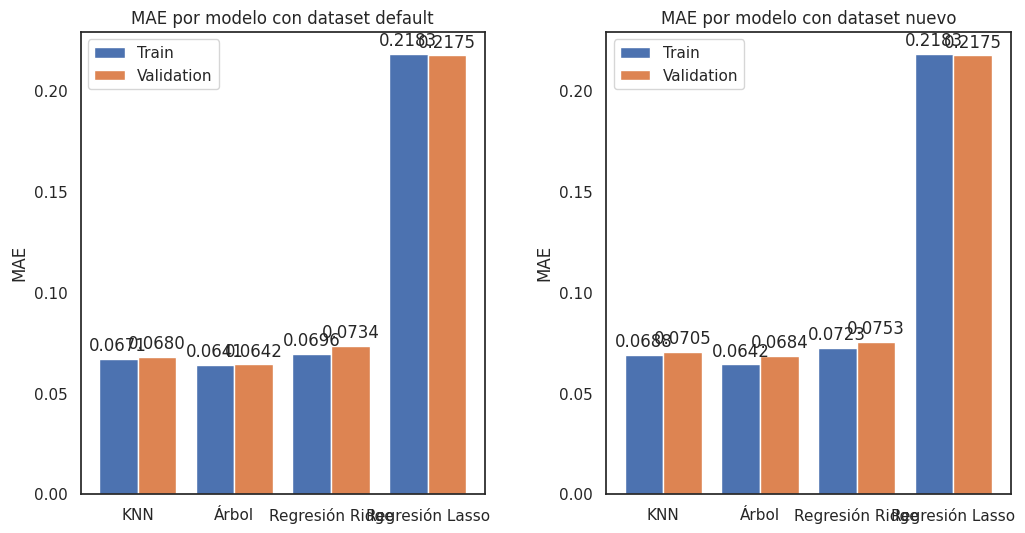

In [247]:
# Agregar las etiquetas a las barras
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.4f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Crear los datos para los modelos
modelos = ['KNN', 'Árbol', 'Regresión Ridge', 'Regresión Lasso']
opt_mae_train = [knn_opt_mae_train, tree_opt_mae_train, ridge_opt_mae_train, lasso_opt_mae_train]
opt_mae_val = [knn_opt_mae_val, tree_opt_mae_val, ridge_opt_mae_val, lasso_opt_mae_val]

new_opt_mae_train = [new_knn_opt_mae_train, new_tree_opt_mae_train, new_ridge_opt_mae_train, new_lasso_opt_mae_train]
new_opt_mae_val = [new_knn_opt_mae_val, new_tree_opt_mae_val, new_ridge_opt_mae_val, new_lasso_opt_mae_val]

# Configurar la figura con dos conjuntos de ejes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Graficar la primera gráfica en el primer conjunto de ejes
ind = np.arange(len(modelos))
ancho = 0.4
rects1 = ax1.bar(ind - ancho/2, opt_mae_train, ancho, label='Train')
rects2 = ax1.bar(ind + ancho/2, opt_mae_val, ancho, label='Validation')
ax1.set_ylabel('MAE')
ax1.set_title('MAE por modelo con dataset default')
ax1.set_xticks(ind)
ax1.set_xticklabels(modelos)
ax1.legend()
autolabel(rects1, ax1)
autolabel(rects2, ax1)

# Graficar la segunda gráfica en el segundo conjunto de ejes
rects1_2 = ax2.bar(ind - ancho/2, new_opt_mae_train, ancho, label='Train')
rects2_2 = ax2.bar(ind + ancho/2, new_opt_mae_val, ancho, label='Validation')
ax2.set_ylabel('MAE')
ax2.set_title('MAE por modelo con dataset nuevo')
ax2.set_xticks(ind)
ax2.set_xticklabels(modelos)
ax2.legend()
autolabel(rects1_2, ax2)
autolabel(rects2_2, ax2)

# Ajustar el margen entre las dos gráficas
fig.subplots_adjust(wspace=0.3)

# Mostrar la gráfica
plt.show()

Respecto al dataset original, se puede comprobar fácilmente que el peor modelo de los cuatro es el Lasso. Los otros tres modelos obtienen unos valores de error muy parecidos, y lo que es más importante, estos tienen un error bajo a la hora de realizar las predicciones, prácticamente igual al error de entrenamiento. El modelo el cúal obtiene unos mejores valores en las pruebas es el árbol de decisón, aunque sus valores son muy próximos al KNN.

Los valores obtenidos con el conjunto del EDA son ligeramente peores, aunque todas las gráficas mantienen la misma forma que las del conjunto original.


### Comparativa del RMSE

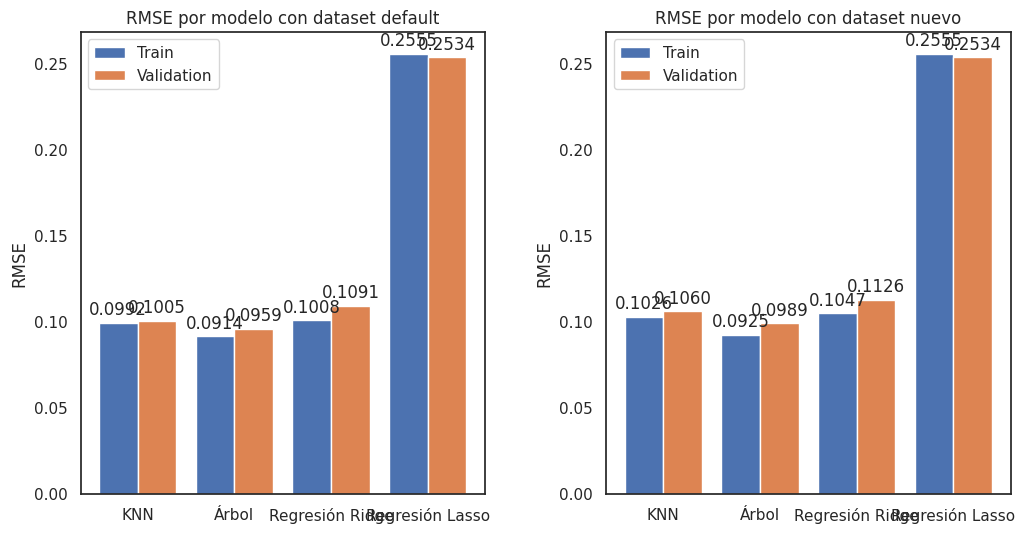

In [248]:
# Agregar las etiquetas a las barras
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.4f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Crear los datos para los modelos
modelos = ['KNN', 'Árbol', 'Regresión Ridge', 'Regresión Lasso']
opt_rmse_train = [knn_opt_rmse_train, tree_opt_rmse_train, ridge_opt_rmse_train, lasso_opt_rmse_train]
opt_rmse_val = [knn_opt_rmse_val, tree_opt_rmse_val, ridge_opt_rmse_val, lasso_opt_rmse_val]

new_opt_rmse_train = [new_knn_opt_rmse_train, new_tree_opt_rmse_train, new_ridge_opt_rmse_train, new_lasso_opt_rmse_train]
new_opt_rmse_val = [new_knn_opt_rmse_val, new_tree_opt_rmse_val, new_ridge_opt_rmse_val, new_lasso_opt_rmse_val]

# Configurar la figura con dos conjuntos de ejes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Graficar la primera gráfica en el primer conjunto de ejes
ind = np.arange(len(modelos))
ancho = 0.4
rects1 = ax1.bar(ind - ancho/2, opt_rmse_train, ancho, label='Train')
rects2 = ax1.bar(ind + ancho/2, opt_rmse_val, ancho, label='Validation')
ax1.set_ylabel('RMSE')
ax1.set_title('RMSE por modelo con dataset default')
ax1.set_xticks(ind)
ax1.set_xticklabels(modelos)
ax1.legend()
autolabel(rects1, ax1)
autolabel(rects2, ax1)

# Graficar la segunda gráfica en el segundo conjunto de ejes
rects1_2 = ax2.bar(ind - ancho/2, new_opt_rmse_train, ancho, label='Train')
rects2_2 = ax2.bar(ind + ancho/2, new_opt_rmse_val, ancho, label='Validation')
ax2.set_ylabel('RMSE')
ax2.set_title('RMSE por modelo con dataset nuevo')
ax2.set_xticks(ind)
ax2.set_xticklabels(modelos)
ax2.legend()
autolabel(rects1_2, ax2)
autolabel(rects2_2, ax2)

# Ajustar el margen entre las dos gráficas
fig.subplots_adjust(wspace=0.3)

# Mostrar la gráfica
plt.show()

Respecto al dataset original, la gráfica obtenida es altamente parecida a la del MAE, siendo el peor modelo el Lasso, aunque esta vez se pueden observar unas diferencias ligeramente mayores entre los valores de error de los distintos modelos. Pese a esto, el árbol de decisión sigue siendo la mejor opción, seguido muy de cerca del KNN.

### Comparativa del tiempo de entrenamiento

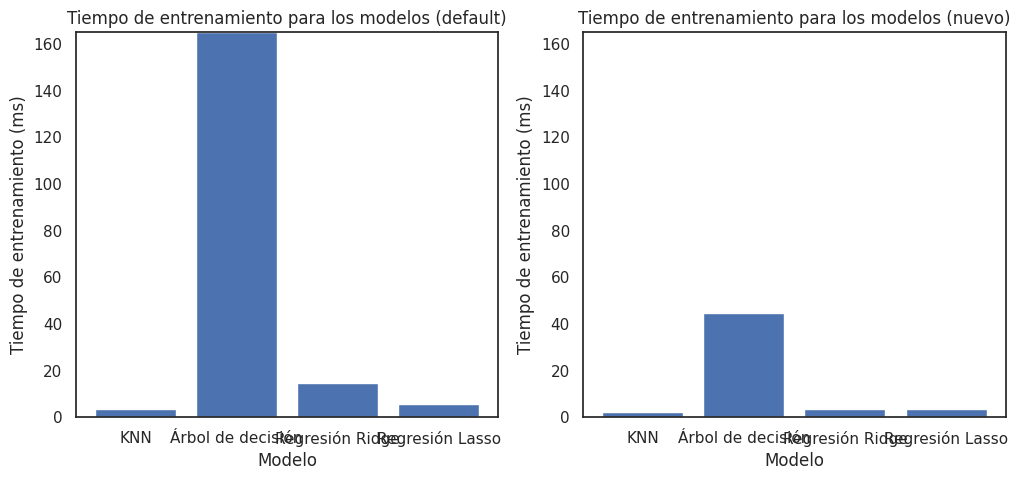

In [249]:
# Obtener el valor máximo de tiempo de entrenamiento entre ambos dataframes
max_time = max(df.loc['Tiempo de entrenamiento (ms)'].max(), new_df.loc['Tiempo de entrenamiento (ms)'].max())

# Gráfico DEFAULT
# Obtener los valores de tiempo de entrenamiento para cada modelo
time_values = df.loc['Tiempo de entrenamiento (ms)']

# Crear un gráfico de barras
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].bar(time_values.index, time_values.values)

# Personalizar el gráfico
axs[0].set_title('Tiempo de entrenamiento para los modelos (default)')
axs[0].set_xlabel('Modelo')
axs[0].set_ylabel('Tiempo de entrenamiento (ms)')
axs[0].set_ylim([0, max_time])

# Gráfico NUEVO
# Obtener los valores de tiempo de entrenamiento para cada modelo
new_time_values = new_df.loc['Tiempo de entrenamiento (ms)']

# Crear un gráfico de barras
axs[1].bar(new_time_values.index, new_time_values.values)

# Personalizar el gráfico
axs[1].set_title('Tiempo de entrenamiento para los modelos (nuevo)')
axs[1].set_xlabel('Modelo')
axs[1].set_ylabel('Tiempo de entrenamiento (ms)')
axs[1].set_ylim([0, max_time])

plt.show()

Respecto al dataset original, el peor valor de tiempo se obtiene en el modelo el cual arrojaba los mejores resultados del MAE y del RMSE, el árbol de decisón, mientras que el mejor valor temporal se obtiene en el KNN, el cúal es el segundo mejor modelo.

Debido a la tan pequeña diferencia entre los errores obtenidos del árbol de decisión y del KNN, se podría optar por el segundo como mejor modelo si el dataset tuviese una cantidad de datos ampliamente más elevada, debido a que se realiza el proceso de entrenamiento en menos tiempo. Esta decisión depende completamente de los intereses del usuario.

## **4.5.COMPARATIVA MODELOS BÁSICOS**

Respecto del dataset original, como era de esperar,se obtienen unos errores menores en los modelos con hiperparámetros optimizados en relación con los modelos sin optimizar, debido esto a que gracias al uso del ParamGrid, se pueden buscar los valores que harán que mejor se ajuste el modelo al dataset. El modelo básico el cúal genera unos errores menores es el árbol de decisión, cuyos hiperparámetros óptimos se pueden ver al ejecutar el código.

Al igual que en el dataset original, el mejor modelo del nuevo conjunto de datos es el árbol de decisión, el cúal aunque sus resultados del MAE y RMSE sean ligeramente peores, el tiempo de entrenamiento se ve ampliamente reducido.



# **5.MODELOS AVANZADOS**

## **5.1.OMISIÓN DE HIPERPARÁMETROS**

### Modelo SVMs 

In [250]:
# Crear un clasificador SVM sin ajuste de hiperparámetros
clf = SVR()


# ************ DATASET DEFAULT
# Iniciar la medición del tiempo
start_time = time.time()

# Entrenar el clasificador en los datos de entrenamiento
svc_fit = clf.fit(X_train_norm, Y_train_norm) #X_train_train_norm, Y_train_train_norm

# Finalizar la medición del tiempo y calculo del tiempo
end_time = time.time()
svm_training_time = round((end_time - start_time) * 1000, 6)

# Calcular las predicciones y los errores de validación
y_pred_val = svc_fit.predict(X_train_val_norm)
svm_mae_val = mean_absolute_error(Y_train_val_norm, y_pred_val)
svm_rmse_val = np.sqrt(mean_squared_error(Y_train_val_norm, y_pred_val))

# Calcular las predicciones y los errores de entrenamiento
y_pred_train = svc_fit.predict(X_train_train_norm)
svm_mae_train = mean_absolute_error(Y_train_train_norm, y_pred_train)
svm_rmse_train = np.sqrt(mean_squared_error(Y_train_train_norm, y_pred_train))


# ************** DATASET NUEVO
start_time = time.time()

new_svc_fit = clf.fit(new_X_train_norm, new_Y_train_norm)

end_time = time.time()
new_svm_training_time = round((end_time - start_time) * 1000, 6)

new_y_pred_val = new_svc_fit.predict(new_X_train_val_norm)
new_svm_mae_val = mean_absolute_error(new_Y_train_val_norm, new_y_pred_val)
new_svm_rmse_val = np.sqrt(mean_squared_error(new_Y_train_val_norm, new_y_pred_val))

new_y_pred_train = svc_fit.predict(new_X_train_train_norm)
new_svm_mae_train = mean_absolute_error(new_Y_train_train_norm, new_y_pred_train)
new_svm_rmse_train = np.sqrt(mean_squared_error(new_Y_train_train_norm, new_y_pred_train))

### Modelo Random Forests 

In [251]:
# Crear modelo con los parámetros por defecto
rf = RandomForestRegressor()


# ************ DATASET DEFAULT
# Iniciar la medición del tiempo
start_time = time.time()

# Entrenar el modelo
rf_fit = rf.fit(X_train_train_norm, Y_train_train_norm)

# Finalizar la medición del tiempo y calculo del tiempo
end_time = time.time()
rf_training_time = round((end_time - start_time) * 1000, 6)

# Calcular las predicciones y los errores de validación
y_pred_val = rf_fit.predict(X_train_val_norm)
rf_mae_val = mean_absolute_error(Y_train_val_norm, y_pred_val)
rf_rmse_val = np.sqrt(mean_squared_error(Y_train_val_norm, y_pred_val))

# Calcular las predicciones y los errores de entrenamiento
y_pred_train = rf_fit.predict(X_train_train_norm)
rf_mae_train = mean_absolute_error(Y_train_train_norm, y_pred_train)
rf_rmse_train = np.sqrt(mean_squared_error(Y_train_train_norm, y_pred_train))


# ************** DATASET NUEVO
start_time = time.time()

new_rf_fit = rf.fit(new_X_train_train_norm, new_Y_train_train_norm)

end_time = time.time()
new_rf_training_time = round((end_time - start_time) * 1000, 6)

new_y_pred_val = new_rf_fit.predict(new_X_train_val_norm)
new_rf_mae_val = mean_absolute_error(new_Y_train_val_norm, new_y_pred_val)
new_rf_rmse_val = np.sqrt(mean_squared_error(new_Y_train_val_norm, new_y_pred_val))

new_y_pred_train = new_rf_fit.predict(new_X_train_train_norm)
new_rf_mae_train = mean_absolute_error(new_Y_train_train_norm, new_y_pred_train)
new_rf_rmse_train = np.sqrt(mean_squared_error(new_Y_train_train_norm, new_y_pred_train))

## **5.2.COMPARATIVA OMISIÓN DE HIPERPARÁMETROS**

En este apartado se mostrarán los resultados del MAE y RMSE de train y validation de los modelos de SMV y Random Forest, tanto con el dataset original como con el obtenido tras realizar el EDA. Estos valores serán mostrados en forma de gráficas comparativas de los distintos modelos.
A continuación se muestran dos tablas las cuales recogen los valores obtenidos.


In [252]:
# ********** DATASET DEFAULT **********
# Crear un diccionario con los valores de MAE, RMSE y tiempo de ejecución de cada modelo
data = {'SVM': [svm_mae_train, svm_mae_val, svm_rmse_train, svm_rmse_val, svm_training_time],
        'Random forest': [rf_mae_train, rf_mae_val, rf_rmse_train, rf_rmse_val, rf_training_time]}

# Crear un DataFrame de pandas con los valores del diccionario y especificar las etiquetas de filas y columnas
df = pd.DataFrame(data, index=['MAE train', 'MAE val', 'RMSE train', 'RMSE val', 'Tiempo de entrenamiento (ms)'])


# ********** DATASET NUEVO **********
new_data = {'SVM': [new_svm_mae_train, new_svm_mae_val, new_svm_rmse_train, new_svm_rmse_val, new_svm_training_time],
        'Random forest': [new_rf_mae_train, new_rf_mae_val, new_rf_rmse_train, new_rf_rmse_val, new_rf_training_time]}

new_df = pd.DataFrame(new_data, index=['MAE train', 'MAE val', 'RMSE train', 'RMSE val', 'Tiempo de entrenamiento (ms)'])

print("Tabla dataset default")
display(df)

print("\n")
print("Tabla dataset nuevo")
display(new_df)

Tabla dataset default


,SVM,Random forest
MAE train,0.074551,0.026323
MAE val,0.071715,0.074411
RMSE train,0.098522,0.039563
RMSE val,0.100699,0.114888
Tiempo de entrenamiento (ms),520.737886,13807.168484




Tabla dataset nuevo


,SVM,Random forest
MAE train,0.079631,0.025917
MAE val,0.075939,0.075139
RMSE train,0.103249,0.039154
RMSE val,0.105361,0.116461
Tiempo de entrenamiento (ms),429.663658,4719.691753


### Comparativa del MAE

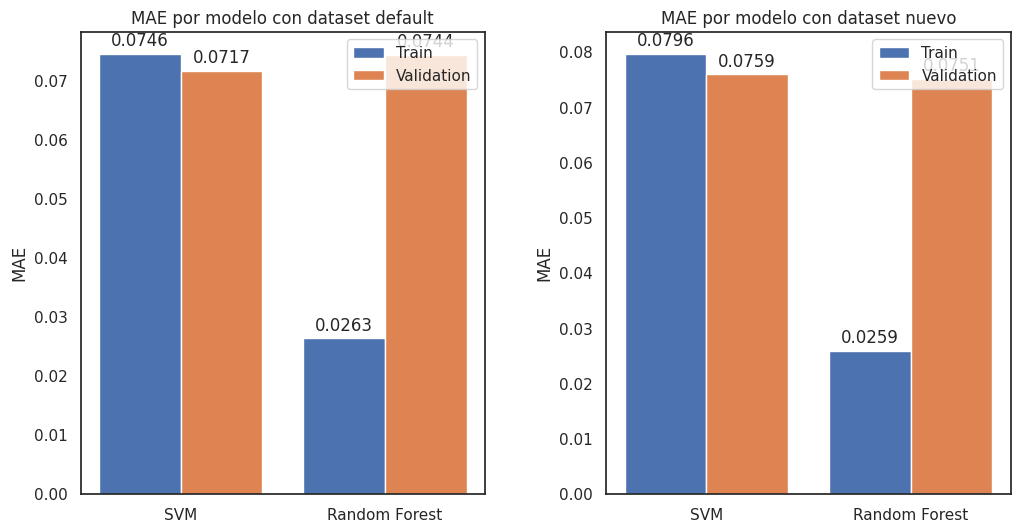

In [253]:
# Agregar las etiquetas a las barras
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.4f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Crear los datos para los modelos
modelos = ['SVM', 'Random Forest']
mae_train = [svm_mae_train, rf_mae_train]
mae_val = [svm_mae_val, rf_mae_val]

new_mae_train = [new_svm_mae_train, new_rf_mae_train]
new_mae_val = [new_svm_mae_val, new_rf_mae_val]

# Configurar la figura con dos conjuntos de ejes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Graficar la primera gráfica en el primer conjunto de ejes
ind = np.arange(len(modelos))
ancho = 0.4
rects1 = ax1.bar(ind - ancho/2, mae_train, ancho, label='Train')
rects2 = ax1.bar(ind + ancho/2, mae_val, ancho, label='Validation')
ax1.set_ylabel('MAE')
ax1.set_title('MAE por modelo con dataset default')
ax1.set_xticks(ind)
ax1.set_xticklabels(modelos)
ax1.legend()
autolabel(rects1, ax1)
autolabel(rects2, ax1)

# Graficar la segunda gráfica en el segundo conjunto de ejes
rects1_2 = ax2.bar(ind - ancho/2, new_mae_train, ancho, label='Train')
rects2_2 = ax2.bar(ind + ancho/2, new_mae_val, ancho, label='Validation')
ax2.set_ylabel('MAE')
ax2.set_title('MAE por modelo con dataset nuevo')
ax2.set_xticks(ind)
ax2.set_xticklabels(modelos)
ax2.legend()
autolabel(rects1_2, ax2)
autolabel(rects2_2, ax2)

# Ajustar el margen entre las dos gráficas
fig.subplots_adjust(wspace=0.3)

# Mostrar la gráfica
plt.show()

Utilizando el dataset original, podemos comprobar que el menor error de train lo tiene el Random Forest, aunque al observar su valor de validation, se puede llegar a la conclusión de que este está sobreentrenando, debido a la gran diferencia entre los dos errores. Con el SVM se obtienen errores más altos pero estos se encuentran más equilibrados.

Utilizando el nuevo dataset se llega a la misma conclusión, ya que las gráficas son iguales, la única diferencia son unos errores ligeramente más altos con estos datos.


### Comparativa del RMSE

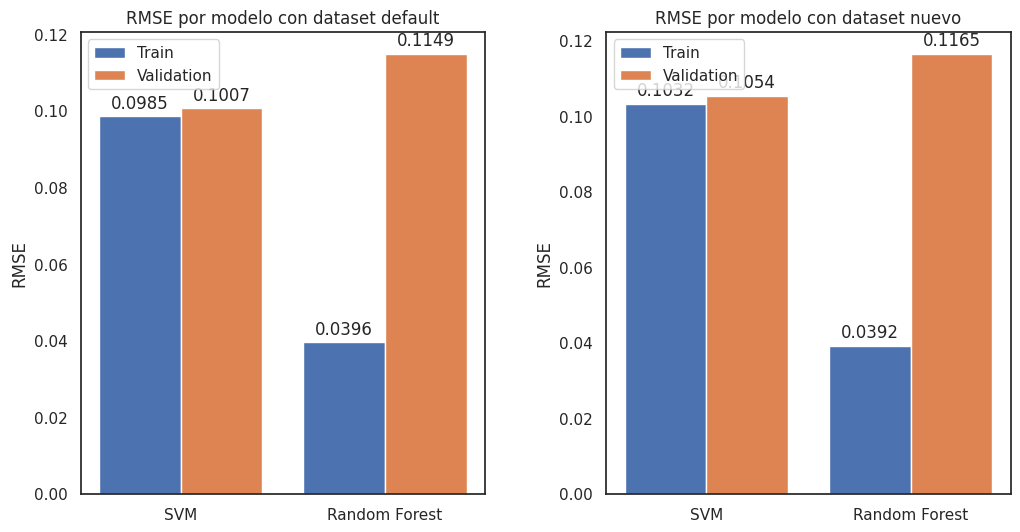

In [254]:
# Agregar las etiquetas a las barras
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.4f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Crear los datos para los modelos
modelos = ['SVM', 'Random Forest']
rmse_train = [svm_rmse_train, rf_rmse_train]
rmse_val = [svm_rmse_val, rf_rmse_val]

new_rmse_train = [new_svm_rmse_train, new_rf_rmse_train]
new_rmse_val = [new_svm_rmse_val, new_rf_rmse_val]

# Configurar la figura con dos conjuntos de ejes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Graficar la primera gráfica en el primer conjunto de ejes
ind = np.arange(len(modelos))
ancho = 0.4
rects1 = ax1.bar(ind - ancho/2, rmse_train, ancho, label='Train')
rects2 = ax1.bar(ind + ancho/2, rmse_val, ancho, label='Validation')
ax1.set_ylabel('RMSE')
ax1.set_title('RMSE por modelo con dataset default')
ax1.set_xticks(ind)
ax1.set_xticklabels(modelos)
ax1.legend()
autolabel(rects1, ax1)
autolabel(rects2, ax1)

# Graficar la segunda gráfica en el segundo conjunto de ejes
rects1_2 = ax2.bar(ind - ancho/2, new_rmse_train, ancho, label='Train')
rects2_2 = ax2.bar(ind + ancho/2, new_rmse_val, ancho, label='Validation')
ax2.set_ylabel('RMSE')
ax2.set_title('RMSE por modelo con dataset nuevo')
ax2.set_xticks(ind)
ax2.set_xticklabels(modelos)
ax2.legend()
autolabel(rects1_2, ax2)
autolabel(rects2_2, ax2)

# Ajustar el margen entre las dos gráficas
fig.subplots_adjust(wspace=0.3)

# Mostrar la gráfica
plt.show()

Al igual que con el MAE, con el RMSE se llega a una conclusión parecida, se aprecia un sobreajuste de los datos en el modelo de Random Forest en los dos conjuntos, y el modelo más equilibrado es el del SVM.

### Comparativa del tiempo de entrenamiento

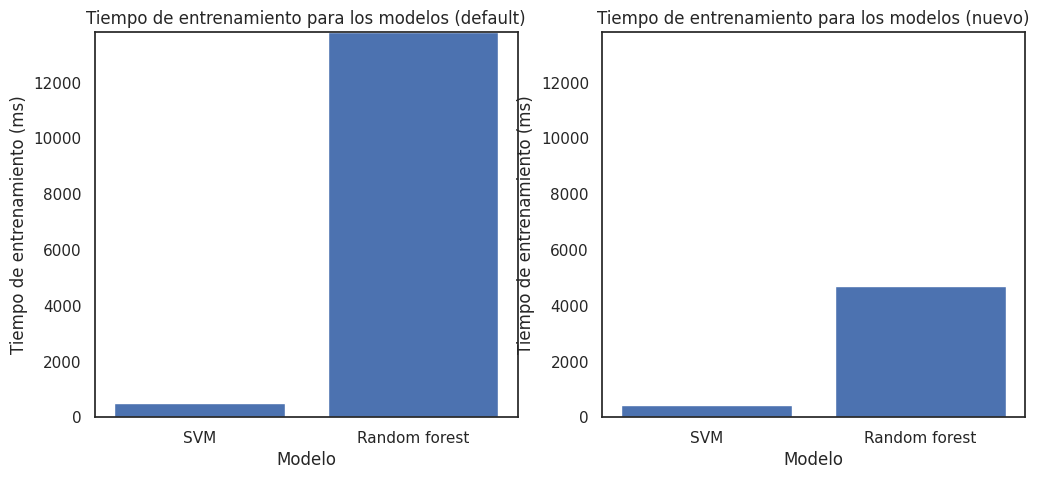

In [255]:
# Obtener el valor máximo de tiempo de entrenamiento entre ambos dataframes
max_time = max(df.loc['Tiempo de entrenamiento (ms)'].max(), new_df.loc['Tiempo de entrenamiento (ms)'].max())

# Gráfico DEFAULT
# Obtener los valores de tiempo de entrenamiento para cada modelo
time_values = df.loc['Tiempo de entrenamiento (ms)']

# Crear un gráfico de barras
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].bar(time_values.index, time_values.values)

# Personalizar el gráfico
axs[0].set_title('Tiempo de entrenamiento para los modelos (default)')
axs[0].set_xlabel('Modelo')
axs[0].set_ylabel('Tiempo de entrenamiento (ms)')
axs[0].set_ylim([0, max_time])

# Gráfico NUEVO
# Obtener los valores de tiempo de entrenamiento para cada modelo
new_time_values = new_df.loc['Tiempo de entrenamiento (ms)']

# Crear un gráfico de barras
axs[1].bar(new_time_values.index, new_time_values.values)

# Personalizar el gráfico
axs[1].set_title('Tiempo de entrenamiento para los modelos (nuevo)')
axs[1].set_xlabel('Modelo')
axs[1].set_ylabel('Tiempo de entrenamiento (ms)')
axs[1].set_ylim([0, max_time])

plt.show()

En cuanto a los tiempos, en los dos datasets el modelo que arroja mejores tiempos en el entrenamiento es el SVM, siendo este valor ligeramente inferior en el dataset nuevo. Se puede observar también que hay una gran reducción del tiempo de entrenamiento entre el dataset nuevo y el original en el Random Forest.

## **5.3.OPTIMIZACIÓN DE HIPERPARÁMETROS**

### Modelo SVMs 

In [256]:
# Crear el modelo SVR
svm = SVR()

# Definir los parámetros a optimizar
param_grid = {'C': [13, 14, 15], 'epsilon': [0, 0.01, 0.05], 'gamma': ['scale', 'auto']}  # C: 1, 0.1

scoring = {'MAE': make_scorer(mean_absolute_error, greater_is_better=False), 'RMSE': make_scorer(mean_squared_error, squared=False, greater_is_better=False)}


# ************ DATASET DEFAULT
# Definir la búsqueda por validación cruzada
grid_search = GridSearchCV(svm, param_grid=param_grid, cv=cv, refit='MAE', scoring=scoring) #'neg_mean_squared_error'

# Entrenar el modelo con los datos de entrenamiento
grid_search.fit(X_train_norm, Y_train_norm)

best_C = grid_search.best_params_['C']
best_epsilon = grid_search.best_params_['epsilon']
best_gamma = grid_search.best_params_['gamma']

print(best_C)
print(best_epsilon)
print(best_gamma)

#Crear un nuevo modelo con los mejores valores de los hiperparámetros
svm_opt = SVR(C=best_C, epsilon=best_epsilon, gamma=best_gamma)

#Iniciar la medición del tiempo
start_time = time.time()

#Ajustar el modelo con train_norm
svm_opt_fit_train = svm_opt.fit(X_train_norm, Y_train_norm)

#Finalizar la medición del tiempo y calculo del tiempo
end_time = time.time()
svm_opt_training_time = round((end_time - start_time) * 1000, 6)

#Calcular las predicciones y los errores de validación
y_pred_val = svm_opt_fit_train.predict(X_train_val_norm)
svm_opt_mae_val = mean_absolute_error(Y_train_val_norm, y_pred_val)
svm_opt_rmse_val = np.sqrt(mean_squared_error(Y_train_val_norm, y_pred_val))

#Calcular las predicciones y los errores de entrenamiento
y_pred_train = svm_opt_fit_train.predict(X_train_train_norm)
svm_opt_mae_train = mean_absolute_error(Y_train_train_norm, y_pred_train)
svm_opt_rmse_train = np.sqrt(mean_squared_error(Y_train_train_norm, y_pred_train))


# ************** DATASET NUEVO
new_grid_search = GridSearchCV(svm, param_grid=param_grid, cv=new_cv, refit='MAE', scoring=scoring)

new_grid_search.fit(new_X_train_norm, new_Y_train_norm)

new_best_C = new_grid_search.best_params_['C']
new_best_epsilon = new_grid_search.best_params_['epsilon']
new_best_gamma = new_grid_search.best_params_['gamma']

print(new_best_C)
print(new_best_epsilon)
print(new_best_gamma)

new_svm_opt = SVR(C=new_best_C, epsilon=new_best_epsilon, gamma=new_best_gamma)

start_time = time.time()

new_svm_opt_fit_train = new_svm_opt.fit(new_X_train_norm, new_Y_train_norm)

end_time = time.time()
new_svm_opt_training_time = round((end_time - start_time) * 1000, 6)

new_y_pred_val = new_svm_opt_fit_train.predict(new_X_train_val_norm)
new_svm_opt_mae_val = mean_absolute_error(new_Y_train_val_norm, new_y_pred_val)
new_svm_opt_rmse_val = np.sqrt(mean_squared_error(new_Y_train_val_norm, new_y_pred_val))

new_y_pred_train = new_svm_opt_fit_train.predict(new_X_train_train_norm)
new_svm_opt_mae_train = mean_absolute_error(new_Y_train_train_norm, new_y_pred_train)
new_svm_opt_rmse_train = np.sqrt(mean_squared_error(new_Y_train_train_norm, new_y_pred_train))

15
0.01
auto
15
0
auto


### Modelo Random Forests 

In [259]:
# Crear modelo de Random Forest
rf = RandomForestRegressor()

# Definir grid de hiperparámetros a evaluar
param_grid = {
    'n_estimators': [100],
    'max_depth': [25],  #None
    'max_features': ['sqrt', 0.15, 0.2] #Valores entre 0 y 1 ; Antes: 'sqrt', 'log2' 
}

scoring = {'MAE': make_scorer(mean_absolute_error, greater_is_better=False), 'RMSE': make_scorer(mean_squared_error, squared=False, greater_is_better=False)}


# ************ DATASET DEFAULT
# Definir la búsqueda por validación cruzada
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=cv, refit='MAE', scoring=scoring)

# Entrenar el modelo con los datos de entrenamiento
grid_search.fit(X_train_norm, Y_train_norm)

best_n_estimators = grid_search.best_params_['n_estimators']
best_max_depth = grid_search.best_params_['max_depth']
best_max_features = grid_search.best_params_['max_features']

print(best_n_estimators)
print(best_max_depth)
print(best_max_features)

#Crear un nuevo modelo con los mejores valores de los hiperparámetros
rf_opt = RandomForestRegressor(n_estimators=best_n_estimators, max_depth=best_max_depth, max_features=best_max_features)

#Iniciar la medición del tiempo
start_time = time.time()

#Ajustar el modelo con train_norm
rf_opt_fit_train = rf_opt.fit(X_train_norm, Y_train_norm)

#Finalizar la medición del tiempo y calculo del tiempo
end_time = time.time()
rf_opt_training_time = round((end_time - start_time) * 1000, 6)

#Calcular las predicciones y los errores de validación
y_pred_val = rf_opt_fit_train.predict(X_train_val_norm)
rf_opt_mae_val = mean_absolute_error(Y_train_val_norm, y_pred_val)
rf_opt_rmse_val = np.sqrt(mean_squared_error(Y_train_val_norm, y_pred_val))

#Calcular las predicciones y los errores de entrenamiento
y_pred_train = rf_opt_fit_train.predict(X_train_train_norm)
rf_opt_mae_train = mean_absolute_error(Y_train_train_norm, y_pred_train)
rf_opt_rmse_train = np.sqrt(mean_squared_error(Y_train_train_norm, y_pred_train))


# ************** DATASET NUEVO
new_grid_search = GridSearchCV(rf, param_grid=param_grid, cv=new_cv, refit='MAE', scoring=scoring)

new_grid_search.fit(new_X_train_norm, new_Y_train_norm)

new_best_n_estimators = new_grid_search.best_params_['n_estimators']
new_best_max_depth = new_grid_search.best_params_['max_depth']
new_best_max_features = new_grid_search.best_params_['max_features']

print(best_n_estimators)
print(best_max_depth)
print(best_max_features)

new_rf_opt = RandomForestRegressor(n_estimators=new_best_n_estimators, max_depth=new_best_max_depth, max_features=new_best_max_features)

start_time = time.time()

new_rf_opt_fit_train = new_rf_opt.fit(new_X_train_norm, new_Y_train_norm)

#Finalizar la medición del tiempo y calculo del tiempo
end_time = time.time()
new_rf_opt_training_time = round((end_time - start_time) * 1000, 6)

#Calcular las predicciones y los errores de validación
new_y_pred_val = new_rf_opt_fit_train.predict(new_X_train_val_norm)
new_rf_opt_mae_val = mean_absolute_error(new_Y_train_val_norm, new_y_pred_val)
new_rf_opt_rmse_val = np.sqrt(mean_squared_error(new_Y_train_val_norm, new_y_pred_val))

#Calcular las predicciones y los errores de entrenamiento
new_y_pred_train = new_rf_opt_fit_train.predict(new_X_train_train_norm)
new_rf_opt_mae_train = mean_absolute_error(new_Y_train_train_norm, new_y_pred_train)
new_rf_opt_rmse_train = np.sqrt(mean_squared_error(new_Y_train_train_norm, new_y_pred_train))

100
25
0.15
100
25
0.15


## **5.4.COMPARATIVA OPTIMIZACIÓN DE HIPERPARÁMETROS**





In [261]:
# ********** DATASET DEFAULT **********
# Crear un diccionario con los valores de MAE, RMSE y tiempo de ejecución de cada modelo
data = {'SVM': [svm_opt_mae_train, svm_opt_mae_val, svm_opt_rmse_train, svm_opt_rmse_val, svm_opt_training_time],
        'Random forest': [rf_opt_mae_train, rf_opt_mae_val, rf_opt_rmse_train, rf_opt_rmse_val, rf_opt_training_time]}

# Crear un DataFrame de pandas con los valores del diccionario y especificar las etiquetas de filas y columnas
df = pd.DataFrame(data, index=['MAE train', 'MAE val', 'RMSE train', 'RMSE val', 'Tiempo de entrenamiento (ms)'])


# ********** DATASET NUEVO **********
new_data = {'SVM': [new_svm_opt_mae_train, new_svm_opt_mae_val, new_svm_opt_rmse_train, new_svm_opt_rmse_val, new_svm_opt_training_time],
        'Random forest': [new_rf_opt_mae_train, new_rf_opt_mae_val, new_rf_opt_rmse_train, new_rf_opt_rmse_val, new_rf_opt_training_time]}

new_df = pd.DataFrame(new_data, index=['MAE train', 'MAE val', 'RMSE train', 'RMSE val', 'Tiempo de entrenamiento (ms)'])

print("Tabla dataset default")
display(df)

print("\n")
print("Tabla dataset nuevo")
display(new_df)

Tabla dataset default


,SVM,Random forest
MAE train,0.063008,0.026433
MAE val,0.068361,0.025846
RMSE train,0.099051,0.038833
RMSE val,0.108242,0.039127
Tiempo de entrenamiento (ms),1406.084299,3313.940525




Tabla dataset nuevo


,SVM,Random forest
MAE train,0.065680,0.026654
MAE val,0.071061,0.027375
RMSE train,0.103188,0.039003
RMSE val,0.112831,0.041258
Tiempo de entrenamiento (ms),1854.276419,1612.413645


### Comparativa del MAE

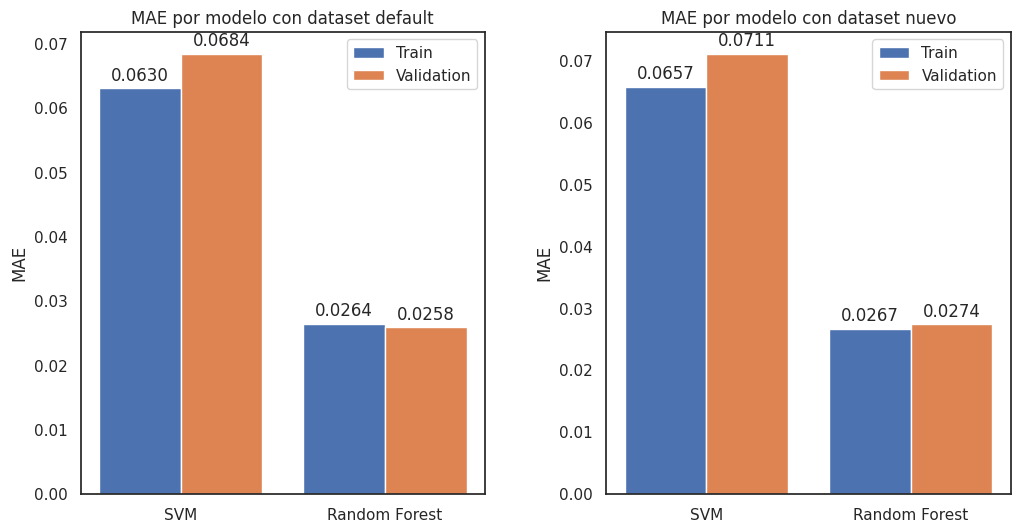

In [262]:
# Agregar las etiquetas a las barras
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.4f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Crear los datos para los modelos
modelos = ['SVM', 'Random Forest']
mae_opt_train = [svm_opt_mae_train, rf_opt_mae_train]
mae_opt_val = [svm_opt_mae_val, rf_opt_mae_val]

new_mae_opt_train = [new_svm_opt_mae_train, new_rf_opt_mae_train]
new_mae_opt_val = [new_svm_opt_mae_val, new_rf_opt_mae_val]

# Configurar la figura con dos conjuntos de ejes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Graficar la primera gráfica en el primer conjunto de ejes
ind = np.arange(len(modelos))
ancho = 0.4
rects1 = ax1.bar(ind - ancho/2, mae_opt_train, ancho, label='Train')
rects2 = ax1.bar(ind + ancho/2, mae_opt_val, ancho, label='Validation')
ax1.set_ylabel('MAE')
ax1.set_title('MAE por modelo con dataset default')
ax1.set_xticks(ind)
ax1.set_xticklabels(modelos)
ax1.legend()
autolabel(rects1, ax1)
autolabel(rects2, ax1)

# Graficar la segunda gráfica en el segundo conjunto de ejes
rects1_2 = ax2.bar(ind - ancho/2, new_mae_opt_train, ancho, label='Train')
rects2_2 = ax2.bar(ind + ancho/2, new_mae_opt_val, ancho, label='Validation')
ax2.set_ylabel('MAE')
ax2.set_title('MAE por modelo con dataset nuevo')
ax2.set_xticks(ind)
ax2.set_xticklabels(modelos)
ax2.legend()
autolabel(rects1_2, ax2)
autolabel(rects2_2, ax2)

# Ajustar el margen entre las dos gráficas
fig.subplots_adjust(wspace=0.3)

# Mostrar la gráfica
plt.show()

### Comparativa del RMSE

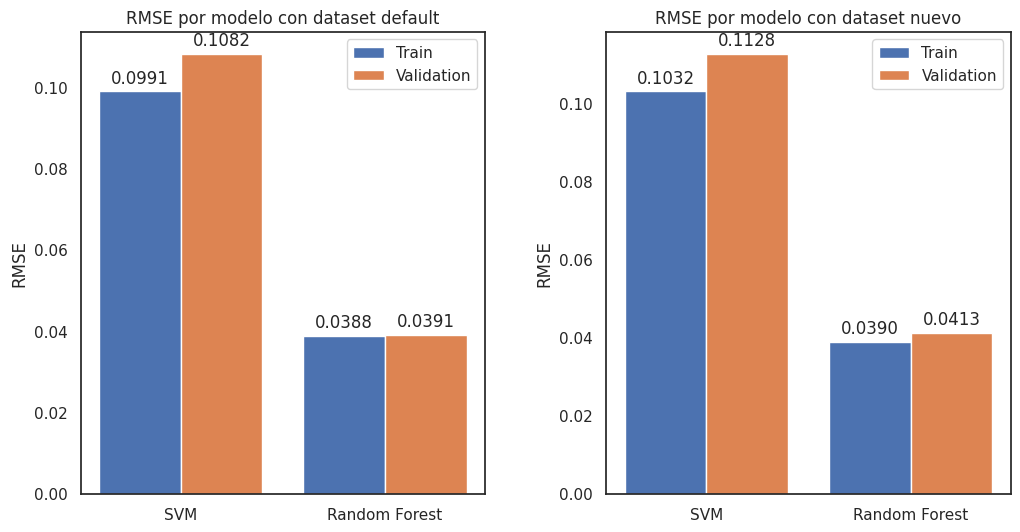

In [263]:
# Agregar las etiquetas a las barras
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.4f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Crear los datos para los modelos
modelos = ['SVM', 'Random Forest']
rmse_opt_train = [svm_opt_rmse_train, rf_opt_rmse_train]
rmse_opt_val = [svm_opt_rmse_val, rf_opt_rmse_val]

new_rmse_opt_train = [new_svm_opt_rmse_train, new_rf_opt_rmse_train]
new_rmse_opt_val = [new_svm_opt_rmse_val, new_rf_opt_rmse_val]

# Configurar la figura con dos conjuntos de ejes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Graficar la primera gráfica en el primer conjunto de ejes
ind = np.arange(len(modelos))
ancho = 0.4
rects1 = ax1.bar(ind - ancho/2, rmse_opt_train, ancho, label='Train')
rects2 = ax1.bar(ind + ancho/2, rmse_opt_val, ancho, label='Validation')
ax1.set_ylabel('RMSE')
ax1.set_title('RMSE por modelo con dataset default')
ax1.set_xticks(ind)
ax1.set_xticklabels(modelos)
ax1.legend()
autolabel(rects1, ax1)
autolabel(rects2, ax1)

# Graficar la segunda gráfica en el segundo conjunto de ejes
rects1_2 = ax2.bar(ind - ancho/2, new_rmse_opt_train, ancho, label='Train')
rects2_2 = ax2.bar(ind + ancho/2, new_rmse_opt_val, ancho, label='Validation')
ax2.set_ylabel('RMSE')
ax2.set_title('RMSE por modelo con dataset nuevo')
ax2.set_xticks(ind)
ax2.set_xticklabels(modelos)
ax2.legend()
autolabel(rects1_2, ax2)
autolabel(rects2_2, ax2)

# Ajustar el margen entre las dos gráficas
fig.subplots_adjust(wspace=0.3)

# Mostrar la gráfica
plt.show()

### Comparativa del tiempo de entrenamiento

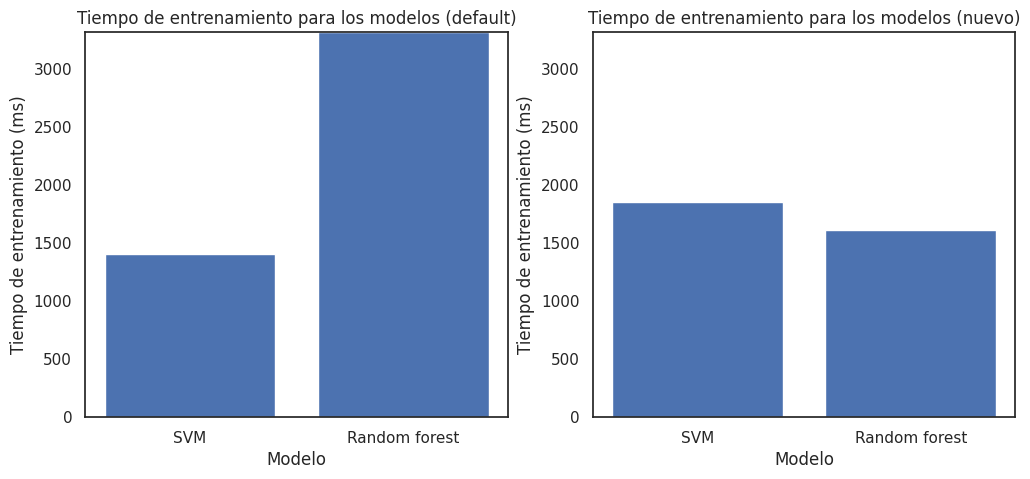

In [264]:
# Obtener el valor máximo de tiempo de entrenamiento entre ambos dataframes
max_time = max(df.loc['Tiempo de entrenamiento (ms)'].max(), new_df.loc['Tiempo de entrenamiento (ms)'].max())

# Gráfico DEFAULT
# Obtener los valores de tiempo de entrenamiento para cada modelo
time_values = df.loc['Tiempo de entrenamiento (ms)']

# Crear un gráfico de barras
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].bar(time_values.index, time_values.values)

# Personalizar el gráfico
axs[0].set_title('Tiempo de entrenamiento para los modelos (default)')
axs[0].set_xlabel('Modelo')
axs[0].set_ylabel('Tiempo de entrenamiento (ms)')
axs[0].set_ylim([0, max_time])

# Gráfico NUEVO
# Obtener los valores de tiempo de entrenamiento para cada modelo
new_time_values = new_df.loc['Tiempo de entrenamiento (ms)']

# Crear un gráfico de barras
axs[1].bar(new_time_values.index, new_time_values.values)

# Personalizar el gráfico
axs[1].set_title('Tiempo de entrenamiento para los modelos (nuevo)')
axs[1].set_xlabel('Modelo')
axs[1].set_ylabel('Tiempo de entrenamiento (ms)')
axs[1].set_ylim([0, max_time])

plt.show()

## **5.5.COMPARATIVA MODELOS AVANZADOS**

# **6.MODELO FINAL**

Explicacion

In [291]:
# Crear modelo de Random Forest
rf = RandomForestRegressor()

# Definir grid de hiperparámetros a evaluar
param_grid = {
    'n_estimators': [100],
    'max_depth': [25],  #None
    'max_features': ['sqrt', 0.15, 0.2] #Valores entre 0 y 1 ; Antes: 'sqrt', 'log2' 
}

scoring = {'MAE': make_scorer(mean_absolute_error, greater_is_better=False), 
           'RMSE': make_scorer(mean_squared_error, squared=False, greater_is_better=False)}


# ************ DATASET DEFAULT
# Definir la búsqueda por validación cruzada
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=cv, refit='MAE', scoring=scoring)

# Entrenar el modelo con los datos de entrenamiento
grid_search.fit(X_train_norm, Y_train_norm)

best_n_estimators = grid_search.best_params_['n_estimators']
best_max_depth = grid_search.best_params_['max_depth']
best_max_features = grid_search.best_params_['max_features']

#Crear un nuevo modelo con los mejores valores de los hiperparámetros
rf_opt = RandomForestRegressor(n_estimators=best_n_estimators, max_depth=best_max_depth, max_features=best_max_features)

#Ajustar el modelo con train_norm
rf_opt_fit_test = rf_opt.fit(X_train_norm, Y_train_norm)

#Calcular las predicciones y los errores de validación
y_pred_test = rf_opt_fit_test.predict(X_test_norm)
rf_opt_mae_test = mean_absolute_error(Y_test_norm, y_pred_test)
rf_opt_rmse_test = np.sqrt(mean_squared_error(Y_test_norm, y_pred_test))
rf_opt_acc_test = accuracy_score(Y_test_norm > 0, y_pred_test > 0)
rf_opt_r2_test = r2_score(Y_test_norm, y_pred_test)


# ************** DATASET NUEVO
new_grid_search = GridSearchCV(rf, param_grid=param_grid, cv=new_cv, refit='MAE', scoring=scoring)

new_grid_search.fit(new_X_train_norm, new_Y_train_norm)

new_best_n_estimators = new_grid_search.best_params_['n_estimators']
new_best_max_depth = new_grid_search.best_params_['max_depth']
new_best_max_features = new_grid_search.best_params_['max_features']

new_rf_opt = RandomForestRegressor(n_estimators=new_best_n_estimators, max_depth=new_best_max_depth, max_features=new_best_max_features)

new_rf_opt_fit_test = new_rf_opt.fit(new_X_train_norm, new_Y_train_norm)

new_y_pred_test = new_rf_opt_fit_test.predict(new_X_test_norm)
new_rf_opt_mae_test = mean_absolute_error(new_Y_test_norm, new_y_pred_test)
new_rf_opt_rmse_test = np.sqrt(mean_squared_error(new_Y_test_norm, new_y_pred_test))
new_rf_opt_acc_test = accuracy_score(new_Y_test_norm > 0, new_y_pred_test > 0)
new_rf_opt_r2_test = r2_score(new_Y_test_norm, new_y_pred_test)


# ************** GUARDADO DE MODELO
# Guardar el modelo en un archivo
with open('random_forest.pkl', 'wb') as file:
    pickle.dump(rf_opt_fit_test, file)

with open('new_random_forest.pkl', 'wb') as file:
    pickle.dump(new_rf_opt_fit_test, file)

Tabla de Datos

In [292]:
# Crear diccionario con los datos
data = {
    'Modelo': ['Default', 'Nuevo'],
    'MAE': [rf_opt_mae_test, new_rf_opt_mae_test],
    'RMSE': [rf_opt_rmse_test, new_rf_opt_rmse_test],
    'R^2': [rf_opt_r2_test, new_rf_opt_r2_test]
}

# Crear dataframe a partir del diccionario
df = pd.DataFrame(data)

# Establecer el modelo como índice del dataframe
df.set_index('Modelo', inplace=True)

# Imprimir el dataframe
df

,MAE,RMSE,R^2
Modelo,,,
Default,0.070364,0.104347,0.820373
Nuevo,0.071229,0.105848,0.815167


Comparativa del MAE

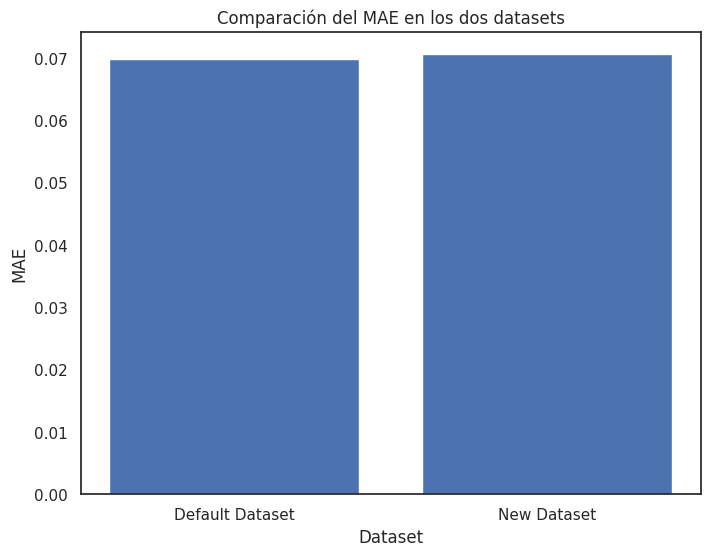

In [275]:
# Definir los datos para la gráfica
mae_values = [rf_opt_mae_test, new_rf_opt_mae_test]
labels = ['Default Dataset', 'New Dataset']

# Crear la gráfica
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(labels, mae_values)

# Definir los títulos y etiquetas de los ejes
ax.set_title('Comparación del MAE en los dos datasets')
ax.set_ylabel('MAE')
ax.set_xlabel('Dataset')

# Mostrar la gráfica
plt.show()

Comparativa del RMSE

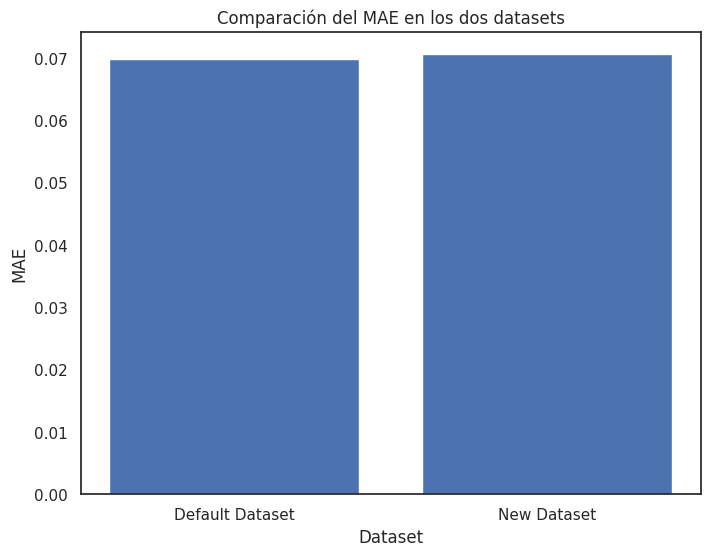

In [276]:
# Definir los datos para la gráfica
mae_values = [rf_opt_mae_test, new_rf_opt_mae_test]
labels = ['Default Dataset', 'New Dataset']

# Crear la gráfica
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(labels, mae_values)

# Definir los títulos y etiquetas de los ejes
ax.set_title('Comparación del MAE en los dos datasets')
ax.set_ylabel('MAE')
ax.set_xlabel('Dataset')

# Mostrar la gráfica
plt.show()

Comparativa del Accuracy

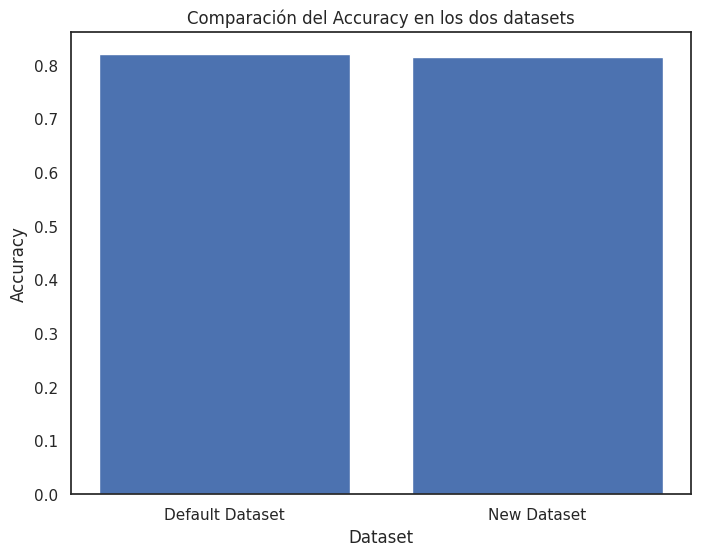

In [294]:
# Definir los datos para la gráfica
mae_values = [rf_opt_r2_test, new_rf_opt_r2_test]
labels = ['Default Dataset', 'New Dataset']

# Crear la gráfica
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(labels, mae_values)

# Definir los títulos y etiquetas de los ejes
ax.set_title('Comparación del Accuracy en los dos datasets')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Dataset')

# Mostrar la gráfica
plt.show()